# Simple 1/V estimator
Source: doi:10.1093/mnras/stw756 (page 7)

## Imports, initial values

In [2]:
import numpy as np
from astropy.coordinates import Distance
from astropy.table import Table, hstack
from astropy.cosmology import Planck18, z_at_value
from astropy import units as u
import astropy.constants as asc
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

import corner
import arviz as az

from astropy.modeling.models import Schechter1D
from astropy.modeling import models, fitting

# custom GAlaxy SELection functions
import gasel as gs

from astropy.io import ascii

from lmfit import Model

## Load the data & prepare/select

In [2]:
full_table = Table.read("/global/homes/j/jgassert/good_z_data_BGSBright.fits")

In [3]:
ztile_cat = Table(full_table, copy = True)

In [4]:
ztile_cat[200000:200002]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64
39627544995046466,47.1530144750498,-9.9420280413704,20221123,0.392895796935432,2.8953034405538e-05,0,3.57381534576416,14.7327671051025,32.9861030578613,GALAXY,131074,0.103536248207092,2.83350610733032
39627544999231628,47.1573816009539,-10.0496555468496,20211024,0.161733006297635,9.1054748174013e-05,0,5.56966972351074,15.1714191436768,28.7859077453613,GALAXY,131074,0.0869847536087036,4.0


### Apply an area selection

Now, this is useful, since we know that in a certain area (which I am using here) is completely coverd by DESI and should therefore have nearly all objects in the dataset

In [6]:
min_ra = 210
min_dec = 30
max_ra = 270
max_dec = 45

area = (np.deg2rad(max_ra) - np.deg2rad(min_ra)) * (np.cos(np.deg2rad(90-max_dec)) - np.cos(np.deg2rad(90-min_dec)))
area = area*((180/np.pi)**2)
print('This patch has an area of {:.2f} sqdeg'.format(area))

This patch has an area of 711.98 sqdeg


In [7]:
sky_sel = True # if true, then make a selection

if sky_sel == False:
    area = gs.omega_sky
else:
    ii = ztile_cat['TARGET_RA']>(min_ra)
    ii &= ztile_cat['TARGET_RA']<(max_ra)
    ii &= ztile_cat['TARGET_DEC']>(min_dec)
    ii &= ztile_cat['TARGET_DEC']<(max_dec)

    ztile_cat = ztile_cat[ii]
print(f"All entries after localization selection: {len(ztile_cat)}, with a sky area of {area}")

All entries after localization selection: 460921, with a sky area of 711.9806682317164


### Apply a redshift selection

In [11]:
ztile_cat  = ztile_cat[ztile_cat["Z"]>0.1]
ztile_cat  = ztile_cat[ztile_cat["Z"]<0.2]

In [13]:
print("All entries after redshift selection", len(ztile_cat))

All entries after good redshift selection 158640


### We need solid fluxes and last but not least only select galaxies (no Stars in particular)

In [15]:
ztile_cat = ztile_cat[ztile_cat["FLUX_R"] > 0.0]
print("All entries after Flux R selection", len(ztile_cat))

All entries after Flux R selection 158640


In [17]:
ztile_cat = ztile_cat[ztile_cat["SPECTYPE"] == "GALAXY"]

In [18]:
print("All entries after Type (Galaxy) selection", len(ztile_cat))

All entries after Type (Galaxy) selection 157990


In [19]:
ztile_cat[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64
39628481163690801,210.00297557756,30.0018511912413,20230319,0.147265851065133,7.4364967849403e-06,0,14.7018299102783,23.1497573852539,32.0197525024414,GALAXY,131074,0.0122371269389987,1.73967480659485
39628481163691077,210.019712252076,30.0780974679947,20230319,0.109962347331243,1.29556967505809e-05,0,15.5349826812744,24.8674926757812,38.4654846191406,GALAXY,131074,0.0144533785060048,0.610406935214996
39628481163691092,210.020357945222,30.092709249839,20230402,0.146660718934836,2.35824592679098e-05,0,75.7559432983398,151.81005859375,246.94108581543,GALAXY,131074,0.01477609295398,3.65472197532654
39628481163691220,210.029430444301,30.0055291830532,20230402,0.109417035366972,5.65207288427875e-06,0,9.63973426818848,15.9258823394775,24.8230361938477,GALAXY,131074,0.0120340930297971,0.637734234333038
39628481163691360,210.039013414964,30.113236216447,20230402,0.107746685027154,2.01875890988739e-05,0,16.691349029541,35.3922004699707,59.1554412841797,GALAXY,131074,0.0146014373749495,1.0


## Calculate some basic quantities!

We first geht the milky way transmission values and then the magnitudes,...

### Calculate the apparent and absolute magnitudes from the given Fluxes (app mag both r and z-band flux, to correct the z limit() with a Planck Cosmology and compare them visually

In [20]:
MW_TRANSMISSION_g = gs.mw_transmission_from_data_table(data = ztile_cat, band = "g")
MW_TRANSMISSION_r = gs.mw_transmission_from_data_table(data = ztile_cat, band = "r")
MW_TRANSMISSION_z = gs.mw_transmission_from_data_table(data = ztile_cat, band = "z")

In [1]:
plt.hist(MW_TRANSMISSION_r, bins = "auto")
plt.xlabel("MW_TRANSMISSION value")
plt.ylabel("bin count")
plt.show()

NameError: name 'plt' is not defined

In [22]:
# calculate the apparent magnitude of every galaxy

app_mag_z = gs.app_mag(ztile_cat["FLUX_Z"], mw_transmission = MW_TRANSMISSION_z)
app_mag_r = gs.app_mag(ztile_cat["FLUX_R"], mw_transmission = MW_TRANSMISSION_r)
app_mag_g = gs.app_mag(ztile_cat["FLUX_G"], mw_transmission = MW_TRANSMISSION_g)

In [23]:
# calculate the absolute magnitude of every galaxy, not yet including a K-correction however with SDSS filters (Planck Cosmology)

### NO K-CORRECTION USED; SHOULD BE ABLE TO IMPLEMENT QUICKLY
abs_mag_z = gs.abs_mag(app_mag_z, ztile_cat["Z"], "z", "g - z", app_mag_g - app_mag_z)
abs_mag_r = gs.abs_mag(app_mag_r, ztile_cat["Z"], "r", "g - r", app_mag_g - app_mag_r)

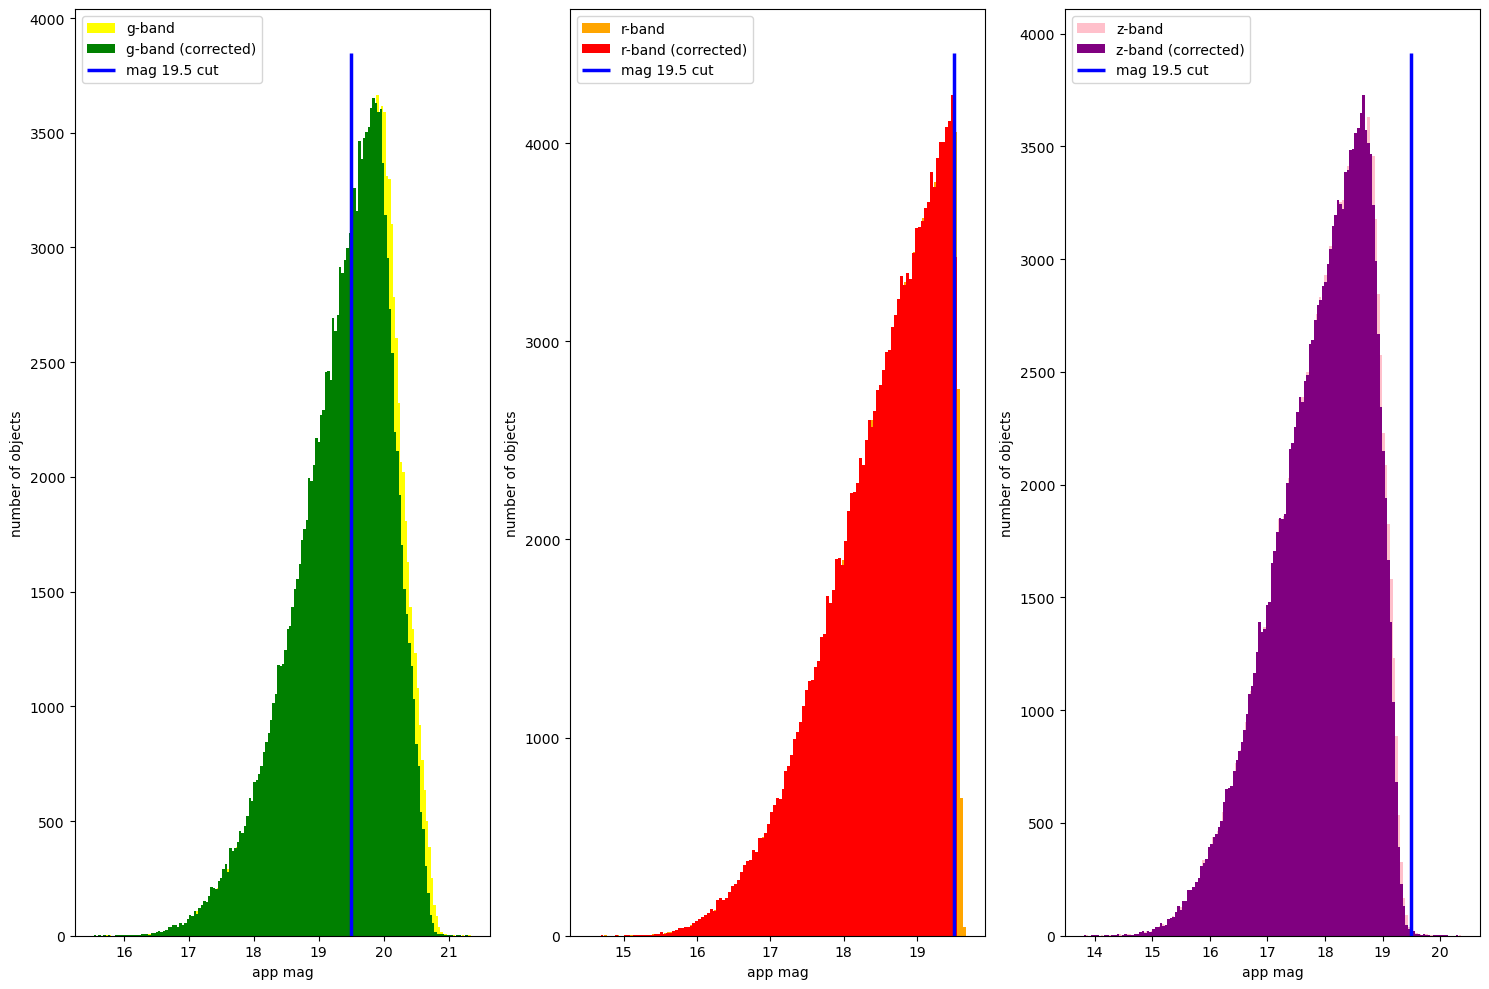

In [24]:
# plot magnitudes

fig, ax = plt.subplots(ncols = 3, figsize  = (15,8))


ax[0].hist(app_mag_g, bins = "auto", label = "g-band", color = "yellow")
ax[1].hist(app_mag_r, bins = "auto", label = "r-band", color = "orange")
ax[2].hist(app_mag_z, bins = "auto", label = "z-band", color = "pink")

ax[0].hist(app_mag_g_corr, bins = "auto", label = "g-band (corrected)", color = "green")
ax[1].hist(app_mag_r_corr, bins = "auto", label = "r-band (corrected)", color = "red")
ax[2].hist(app_mag_z_corr, bins = "auto", label = "z-band (corrected)", color = "purple")


ymin,ymax = ax[0].get_ylim()
for axis in ax:
    ymin,ymax = axis.get_ylim()
    axis.vlines(19.5, ymin, ymax, color = "blue", linewidth = 2.5, label = "mag 19.5 cut")
    axis.set_xlabel("app mag")
    axis.set_ylabel("number of objects")
    axis.legend(loc = "upper left")

plt.tight_layout()
plt.show()


### Compare the colors

In [27]:
corner_plot_data = {"G": app_mag_g, "R": app_mag_r, "Z": app_mag_z}
corner_plot_data = az.from_dict(posterior = corner_plot_data, sample_stats={"diverging": app_mag_r>19.5})

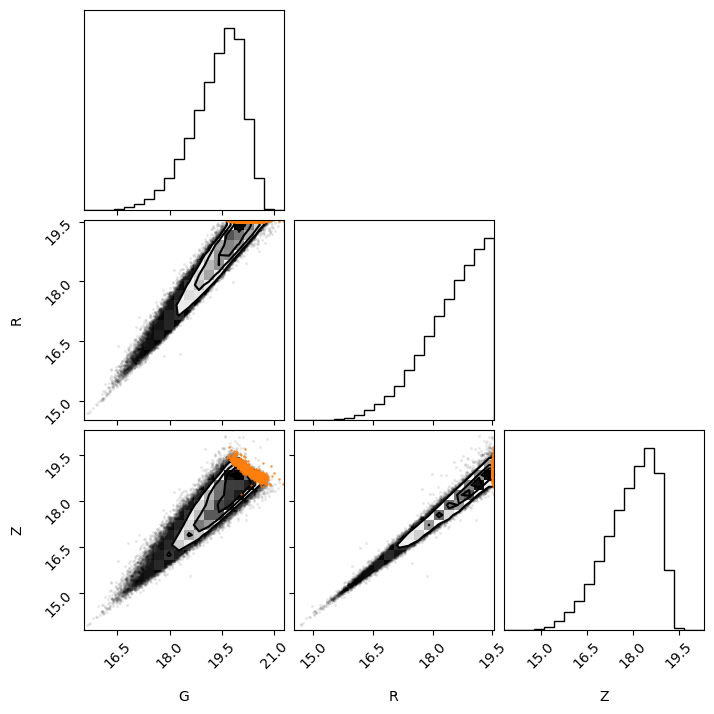

In [28]:
figure = corner.corner(corner_plot_data, divergences = True)

In [29]:
diff = [app_mag_r[q]-app_mag_z[q] for q in range(len(app_mag_r))]

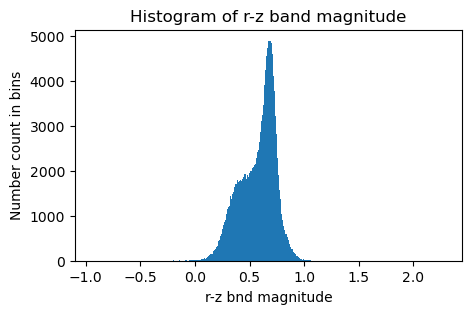

In [30]:
fig, ax = plt.subplots(figsize = (5,3))

ax.hist(diff, bins='auto')
ax.set_xlabel("r-z bnd magnitude")
ax.set_ylabel("Number count in bins")
plt.title("Histogram of r-z band magnitude")
plt.show()

In [31]:
avg_diff = np.mean(diff)

In [32]:
avg_diff

0.5754559689711256

### Calculate luminosities and add all the data to the table
We also then define the magnitude limit for the r-band, which is in the case of BGS Bright a clear m<19.5 cut

In [33]:
lums_r = gs.lum(abs_mag_r, band = "r")

In [35]:
offset = 0

In [36]:
m_limit_z = 19.5-avg_diff+offset # r-band magnitude limit for BGS Bright, would need to convert it to z-band magnitude
m_limit_z

In [38]:
m_limit_r = 19.5

In [39]:
lumin_limits_r = gs.lum_lim(lums_r, m_limit_r, app_mag_r)

In [40]:
lumin_limits_z = gs.lum_lim(lums_z, m_limit_z, app_mag_z)

In [41]:
# cornerplot (corner, chainconsumer) to see whether I miss peculiar galaxies
# redshift

In [42]:
ztile_cat = hstack([ztile_cat, Table({"MW_TRANSMISSION_G": MW_TRANSMISSION_g}), Table({"MW_TRANSMISSION_R": MW_TRANSMISSION_r}), Table({"MW_TRANSMISSION_Z": MW_TRANSMISSION_z}), Table({"APP_MAG_G": app_mag_g}),  Table({"APP_MAG_R": app_mag_r}), Table({'APP_MAG_Z': app_mag_z}), Table({'ABS_MAG_R': abs_mag_r}), Table({'ABS_MAG_Z': abs_mag_z}), Table({"LUM_Z": lums_z}), Table({"LUM_R": lums_r}), Table({'LUM_LIMIT_Z': lumin_limits_z}), Table({'LUM_LIMIT_R': lumin_limits_r})])


In [43]:
ztile_cat

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,,,,,W,W,W,W
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39628481163690801,210.00297557756,30.0018511912413,20230319,0.147265851065133,7.4364967849403e-06,0,14.7018299102783,23.1497573852539,32.0197525024414,GALAXY,131074,0.0122371269389987,1.73967480659485,0.963945712900877,0.9757730176571993,0.9865771984368094,19.541702955522247,19.062005902099653,18.721782758037392,-20.20484959358109,-20.557028410662753,1.9420167898159606e+36,6.512887854428094e+35,1.6111963564851217e+36,4.3508685351816274e+35
39628481163691077,210.019712252076,30.0780974679947,20230319,0.109962347331243,1.29556967505809e-05,0,15.5349826812744,24.8674926757812,38.4654846191406,GALAXY,131074,0.0144533785060048,0.610406935214996,0.9575563863841603,0.9714484940146945,0.984165551965143,19.47463395925085,18.979469451618193,18.51999237817197,-19.596750423028066,-20.070348447274654,1.2404549456234903e+36,3.719922841797233e+35,8.545949729558825e+35,2.303147289201714e+35
39628481163691092,210.020357945222,30.092709249839,20230402,0.146660718934836,2.35824592679098e-05,0,75.7559432983398,151.81005859375,246.94108581543,GALAXY,131074,0.01477609295398,3.65472197532654,0.9566295581343927,0.970820388911554,0.9838148775773772,17.753317713367892,17.01459585200611,16.500800080965163,-22.23697923288923,-22.765211246746215,1.4843151313413314e+37,4.232777654632236e+36,1.5923133443431994e+36,4.2900642520472645e+35
39628481163691220,210.029430444301,30.0055291830532,20230402,0.109417035366972,5.65207288427875e-06,0,9.63973426818848,15.9258823394775,24.8230361938477,GALAXY,131074,0.0120340930297971,0.637734234333038,0.9645331754918182,0.976170154625107,0.9867984280204917,20.000630269469802,19.468555056488096,18.998433871171237,-19.101360376641484,-19.583238870848454,7.920218526861412e+35,2.3570994869510645e+35,8.477993913348256e+35,2.289812574303723e+35
39628481163691360,210.039013414964,30.113236216447,20230402,0.107746685027154,2.01875890988739e-05,0,16.691349029541,35.3922004699707,59.1554412841797,GALAXY,131074,0.0146014373749495,1.0,0.9571310533904093,0.9711602738618433,0.9840046497785025,19.39619992032994,18.59595835916116,18.05250613050862,-19.93259230599579,-20.490310138963657,1.8262728871511106e+36,5.068397698971193e+35,8.17994740766942e+35,2.204215381877211e+35
39628481163691393,210.041301313575,30.102212337463,20230319,0.109321821977478,2.61051475044601e-05,0,43.5662384033203,88.6043014526367,152.781967163086,GALAXY,131074,0.0144699234515429,1.53619384765625,0.9575088478618035,0.9714162824002658,0.9841475705280819,18.354981830157108,17.599876431586623,17.022470317931862,-20.96271310291199,-21.554256331778905,4.8656867822233764e+36,1.3089377826280702e+36,8.439460085317456e+35,2.2744142959853438e+35
39628481163691577,210.053398910827,30.0771069380849,20230319,0.147211719036494,4.1463425910529e-05,0,43.8126792907715,114.859153747559,216.536575317383,GALAXY,131074,0.0138619868084788,5.44828176498413,0.9592571805137158,0.972600585515372,0.9848085062122829,18.350838115629337,17.319422286235042,16.644551318276648,-21.94302635214376,-22.631440481214035,1.31225370772831e+37,3.228823485793542e+36,1.607017933981687e+36,4.3332447351878156e+35
39628481163691660,210.058162185709,30.0734582377556,20230402,0.105011890216101,1.13827254147843e-05,0,13.4912528991699,21.0608997344971,29.0350761413574,GALAXY,131074,0.0137314992025495,0.731865644454956,0.9596328588141073,0.9728549726539851,0.984950427390739,19.63013206710973,19.161427956307143,18.82622850930289,-19.30929091002733,-19.65790603175247,8.484065812104147e+35,2.8546319791614233e+35,7.749573828483477e+35,2.0898798045598275

In [44]:
ztile_cat.group_by("ABS_MAG_R")[::-1]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,,,,,W,W,W,W
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39632936873495453,269.107806176739,32.7822244593572,20210530,0.100159423878067,1.95506133134498e-05,0,7.16245460510254,14.0340614318848,22.8667144775391,GALAXY,514,0.0428123697638512,1.0,0.8794414271345916,0.9177747673921182,0.9538216753980818,20.222862593132866,19.53888185026291,19.050658546071386,-18.758870592105197,-19.288921581556004,6.039628817771656e+35,1.7194201007598173e+35,6.78353475903225e+35,1.782110953855109e+35
39632931643200253,259.783752812673,32.5995622364424,20220420,0.100146099078571,7.86497540028608e-06,0,7.7316951751709,14.1715126037598,24.7687110900879,GALAXY,514,0.0387985073029995,1.0,0.8900979181835968,0.9251875484865989,0.9580589578764612,20.15290765450735,19.537033929687123,18.96872207116231,-18.769144614726052,-19.37536261488589,6.54013423151128e+35,1.735767724072829e+35,6.811737101474979e+35,1.7959952364431976e+35
39632941931824143,267.516657913101,32.9860117481311,20210530,0.101556418538784,4.65815184940562e-05,0,5.81501245498657,13.9431762695312,25.0496425628662,GALAXY,514,0.0470555536448956,4.0,0.868314798136016,0.9100030461999487,0.9493626824550708,20.435316383058108,19.536702820892422,18.946576558094996,-18.78390095755236,-19.420000496260844,6.814622683663271e+35,1.7595197487688687e+35,6.954322477091053e+35,1.8200162854528084e+35
39632977113649425,269.469292609991,34.637227880194,20220516,0.100566767552658,8.63458913444008e-06,0,9.94691848754883,14.2894992828369,20.6446876525879,GALAXY,514,0.041362676769495,1.62315726280212,0.8832754498560639,0.9204451763965048,0.9553498950267756,19.871019001524527,19.522452287898197,19.163385359238088,-18.787853594438243,-19.187331858302148,5.500147791728395e+35,1.7659369773940646e+35,6.853475911234574e+35,1.8028355595675233e+35
39628513149455024,264.994859639047,31.4931361021269,20220510,0.100543440076923,9.7415066998714e-06,0,9.99277305603027,14.5287990570068,19.5818252563477,GALAXY,131074,0.0642926022410393,0.552065551280975,0.8245440853956886,0.8791029127411751,0.9314622699939988,19.7913196410402,19.454525004460912,19.193280243148376,-18.805348083522265,-19.129406717224292,5.214399517445924e+35,1.7946220359086366e+35,6.678805371463948e+35,1.721008430945996e+35
39632936831555079,266.254302921589,32.8714744504489,20220427,0.10221422008194,9.71191635112138e-06,0,10.0582284927368,14.1046380996704,18.706521987915,GALAXY,514,0.0509063005447388,1.0,0.8583391250964396,0.9030070812602548,0.9453341310270353,19.827843529667753,19.5158230215197,19.25898072375226,-18.81136475610244,-19.117942509502086,5.1596307199787034e+35,1.804594648419128e+35,7.020908238150565e+35,1.831086554789939e+35
39633006662517273,269.099229450476,36.1792955468316,20220516,0.100691167614267,2.50584311493338e-06,0,9.92671585083008,14.5763664245605,19.1202754974365,GALAXY,514,0.0468540973961353,1.0,0.8688398666554257,0.9103705364631155,0.9495739126853807,19.855335374402735,19.48892229112631,19.240086573261674,-18.81229744164261,-19.10690961266327,5.107465727818696e+35,1.806145524648032e+35,6.830027904138446e+35,1.787811208793817e+35
39632971484890744,222.481723070837,34.5326648524614,20220417,0.100192144485712,8.11168237756011e-06,0,9.18856239318848,14.7542972564697,20.0613861083984,GALAXY,514,0.0212513115257025,1.62566995620728,0.9382213054264331,0.9583030236634523,0.9768049932840358,20.022644305369653,19.5314608236456,19.218617336024934,-18.813964800871403,-19.14757081985268,5.3023689549861765e+35,1.8089213434400117e+35,6.951831963180644e+35,1.862104340732737e+35


### Cutoff in magnitude and look at distribution

In [45]:
ztile_cat_r_cut = ztile_cat

In [46]:
len(ztile_cat_r_cut)

157990

In [47]:
ztile_cat_r_cut = ztile_cat[ztile_cat["APP_MAG_R"] < m_limit_r]
# this step should not be necessary if the BGS TARGET selection would actually work

In [48]:
len(ztile_cat_r_cut)

154636

In [49]:
# ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[ztile_cat_grouped_by_AppMag["Z"]< 0.6]
# ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[ztile_cat_grouped_by_AppMag["Z"]> 0.1]

In [50]:
# ztile_cat_r_cut = ztile_cat_r_cut[ztile_cat_r_cut["Z"] > 0.1]

In [51]:
z_max_data = np.max(ztile_cat_r_cut["Z"])
z_min_data = np.min(ztile_cat_r_cut["Z"])
print("z min and max in sample: ", z_min_data, z_max_data)

z min and max in sample:  0.100001466606648 0.199999718050522


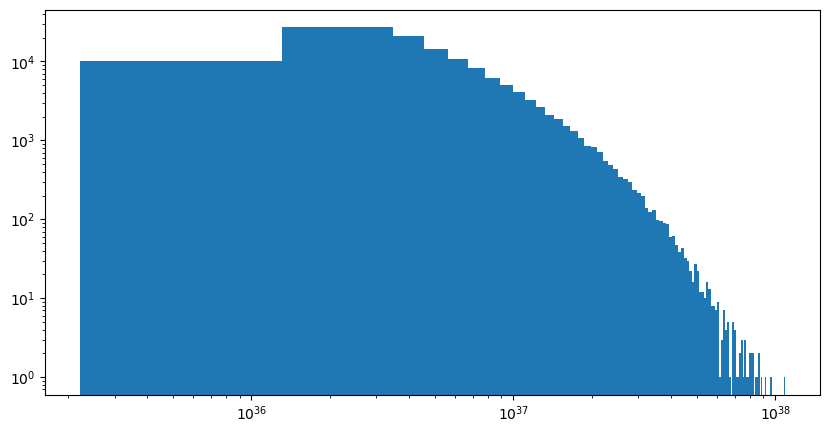

In [52]:
fig, ax = plt.subplots(figsize = (10,5))

ax.hist(ztile_cat_r_cut["LUM_Z"], bins = 100)
ax.set_yscale("log")
ax.set_xscale("log")
#ax.vlines(m_limit_z, 0, 4000)

plt.show()

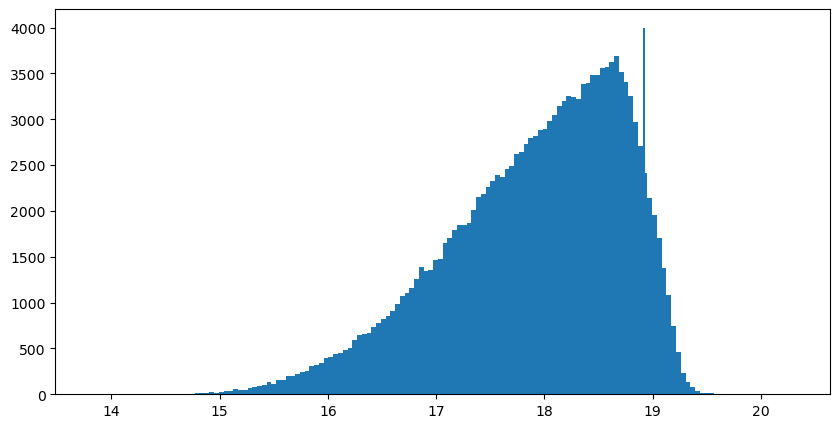

In [53]:
fig, ax = plt.subplots(figsize = (10,5))

ax.hist(ztile_cat_r_cut["APP_MAG_Z"], bins = "auto")
ax.vlines(m_limit_z, 0, 4000)

plt.show()

In [54]:
corner_plot_data = {"G": ztile_cat_r_cut["APP_MAG_G"], "R": ztile_cat_r_cut["APP_MAG_R"], "Z": ztile_cat_r_cut["APP_MAG_Z"]}
corner_plot_data = az.from_dict(posterior = corner_plot_data, sample_stats={"diverging": ztile_cat_r_cut["APP_MAG_Z"]>m_limit_z})

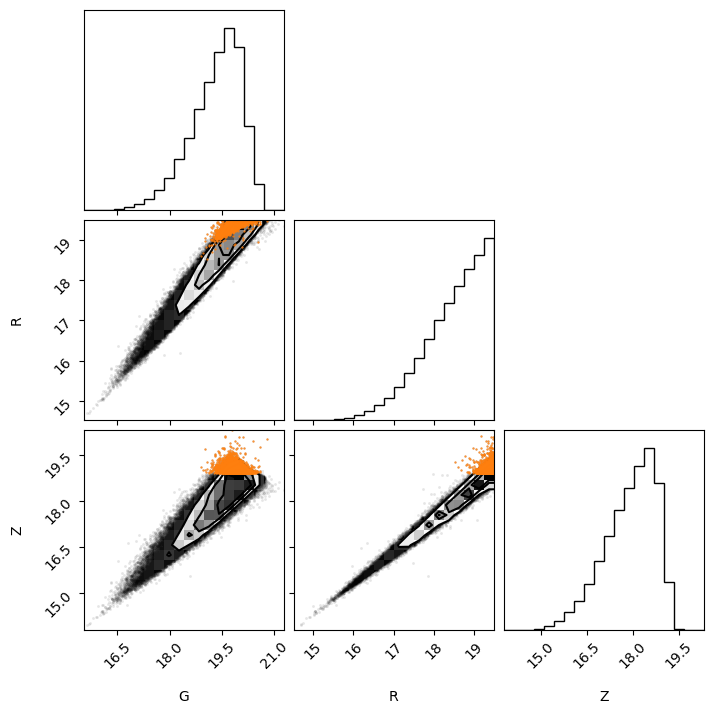

In [55]:
figure = corner.corner(corner_plot_data, divergences = True)

In [56]:
corner_plot_data = {"G-R": ztile_cat_r_cut["APP_MAG_G"]-ztile_cat_r_cut["APP_MAG_R"], "R-Z": ztile_cat_r_cut["APP_MAG_R"] - ztile_cat_r_cut["APP_MAG_Z"]}
corner_plot_data = az.from_dict(posterior = corner_plot_data, sample_stats={"diverging": ztile_cat_r_cut["APP_MAG_Z"]>m_limit_z})

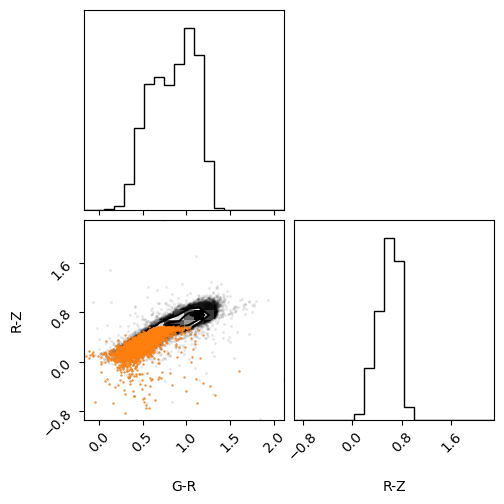

In [57]:
figure = corner.corner(corner_plot_data, divergences = True)

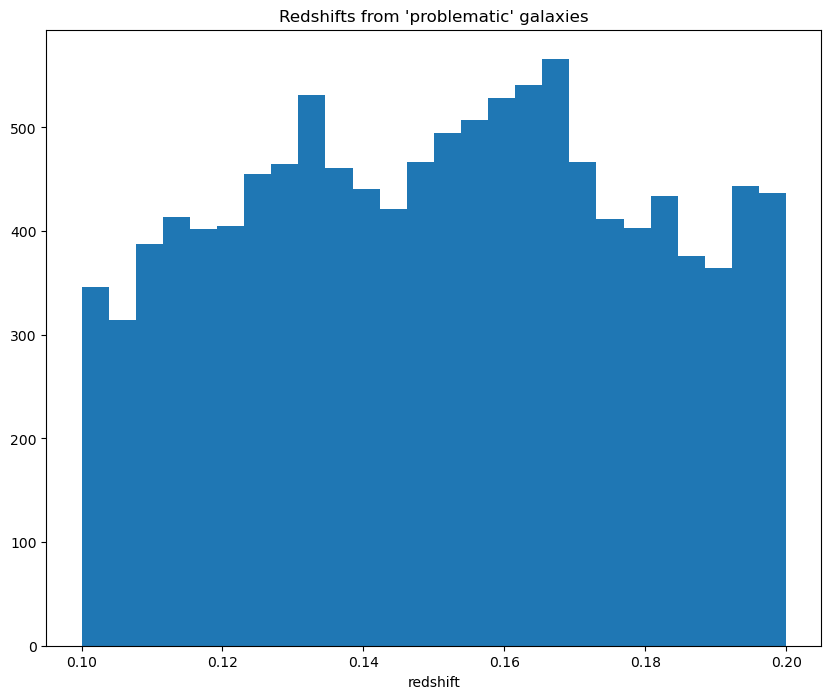

In [58]:
fig, ax = plt.subplots(figsize = (10,8))

ax.hist(ztile_cat_r_cut["Z"][ztile_cat_r_cut["APP_MAG_Z"]>m_limit_z], bins = "auto")
ax.set_xlabel("redshift")
plt.title("Redshifts from 'problematic' galaxies")
plt.show()

In [59]:
len(ztile_cat_r_cut[ztile_cat_r_cut["APP_MAG_R"]>m_limit_z]), len(ztile_cat_r_cut), len(ztile_cat_r_cut[ztile_cat_r_cut["APP_MAG_R"]>m_limit_z])/len(ztile_cat_r_cut)

(54364, 154636, 0.35156108538761993)

### Get 20% lums of all galaxies and plot

In [60]:
ztile_cat_grouped_by_AppMag = ztile_cat_r_cut.group_by("APP_MAG_R")

In [61]:
ztile_cat_grouped_by_AppMag

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,,,,,W,W,W,W
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39628481469876698,231.10032523939,30.0060317803765,20220218,0.117541548034296,3.0193456879753e-05,0,567.128234863281,1479.294921875,2921.36767578125,GALAXY,131074,0.0246070213615894,4.0,0.928821222043855,0.9518796639442276,0.9731918708002536,15.535627150731031,14.521318205500048,13.806530632402676,-24.188233492848724,-24.92706212581637,1.0870924170743059e+38,2.553448833595504e+37,9.75126832189595e+35,2.6040807192153196e+35
39628507831075716,254.146152591578,31.2190333189194,20220611,0.105165498743297,1.56749875574195e-05,0,507.125701904297,1238.060546875,2527.06591796875,GALAXY,131074,0.0322299152612686,3.40961122512817,0.9078162960733455,0.9374477731191605,0.9650338177883058,15.632205881547264,14.698012993871213,13.954814905238134,-23.735846691485484,-24.510533407328822,7.407215484601916e+37,1.6833423097276816e+37,7.616638237051804e+35,2.0201221790843792e+35
39628523106733547,241.70556904543,32.04616600651,20220416,0.115561759225863,1.75658549150001e-05,0,479.943237304688,1233.1513671875,2401.76416015625,GALAXY,131074,0.0321275927126408,4.09121561050415,0.9080950768081291,0.9376400369242884,0.9651428696996592,15.692353611498401,14.702549386355356,14.010153116675445,-23.950970182503823,-24.674755110263984,8.616753319687158e+37,2.052210170931833e+37,9.323678600541475e+35,2.47309950328681e+35
39628502781135246,263.121122807095,31.0367552694681,20220427,0.102572882047058,2.53363813392021e-05,0,448.205017089844,1147.70251464844,2288.72998046875,GALAXY,131074,0.0518155917525291,4.48660135269165,0.8560003077755843,0.9013629629902106,0.9443853518089964,15.702493018057263,14.73767593936292,14.03888670911218,-23.59565348674176,-24.345066550134717,6.360162854803751e+37,1.4794325080891908e+37,7.066515360597815e+35,1.8414737529870773e+35
39632941931824385,267.526684240019,33.0031337734005,20220507,0.101605288969282,2.94300640640392e-05,0,421.258026123047,1075.7470703125,1990.84045410156,GALAXY,514,0.0468755662441254,4.0,0.8687838958892118,0.910331366590204,0.9495514000036936,15.785908934022697,14.818723337854163,14.196205053387585,-23.503386913405652,-24.17170262609274,5.421540001766458e+37,1.3589032209789266e+37,6.962850578913146e+35,1.8225433339842196e+35
39632971543610587,226.685347747288,34.4730937031111,20220218,0.111091297107093,2.5511777158556e-05,0,409.845245361328,1065.51733398438,1991.26159667969,GALAXY,514,0.014938342384994,2.74322962760925,0.9561639205573685,0.9705047532733689,0.9836386180811252,15.91978112756927,14.898592868793243,14.234268132344639,-23.700351389988896,-24.379270886947637,6.563718858886817e+37,1.629199689613586e+37,8.730509944238172e+35,2.3518600022696888e+35
39628491750115211,219.170130966112,30.596034990603,20230509,0.101560750242201,4.89468633745732e-05,0,427.949096679688,1046.24084472656,1976.14050292969,GALAXY,131074,0.013149181380868,4.13373374938965,0.9613111659671353,0.9739910194083987,0.9855840183405554,15.878679682062396,14.922308204653355,14.244689582669398,-23.472174674090382,-24.162640046283446,5.376475047414905e+37,1.3203942740213383e+37,7.220310183675162e+35,1.9481702819120487e+35
39633040225339864,253.882002513839,38.0619977577891,20210709,0.11765623890259,3.1984677076959e-05,0,399.406616210938,981.364501953125,1426.75817871094,GALAXY,514,0.0164773371070623,5.08792209625244,0.9517584346167511,0.96751593320977,0.9819683023709785,15.942778698889624,14.984569453026452,14.594367745892729,-23.744951083992383,-24.151251149479705,5.320372938876047e+37,1.697517250171904e+37,9.859878465267763e+35,2.6524180671873405e+35


In [62]:
ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[::-1]

In [63]:
ztile_cat_grouped_by_AppMag[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,,,,,W,W,W,W
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633030595219808,249.733631644974,37.4732991549371,20230407,0.190212097732953,1.56199338241144e-05,0,8.20665836334229,15.3824548721313,23.3471660614014,GALAXY,514,0.0149062499403954,1.0,0.9562560042706568,0.9705671769012062,0.9836734791685573,20.16601955152961,19.499999875974634,19.061541975499654,-20.37281262549823,-20.82583393216498,2.4875693029707158e+36,7.602541734082257e+35,2.82211278801693e+36,7.602540865631926e+35
39633109762703891,244.161322331921,41.6303271093301,20230413,0.134936473140002,1.33186726712494e-05,0,8.08626842498779,15.5909690856934,26.2269706726074,GALAXY,514,0.00819051265716553,4.0,0.9757220597412367,0.9837188146026058,0.9909958370812224,20.203944925481743,19.49999466843444,18.94330924878598,-19.569072366759297,-20.13375991727381,1.3150600449924357e+36,3.626291478217053e+35,1.3379863106470384e+36,3.626273671162997e+35
39632936244349812,224.717818631139,32.8047872328327,20210617,0.133025712157617,6.50324250296245e-06,0,6.07890319824219,15.3306283950806,30.5596485137939,GALAXY,514,0.0166043099015951,1.81494736671448,0.9513958733216881,0.9672697558455311,0.9818306218303785,20.48634008923794,19.49996912980151,18.767220545348636,-19.51720184100469,-20.266172836231423,1.485630307212855e+36,3.457120354175166e+35,1.285231485319992e+36,3.45702206098581e+35
39633006553465242,261.054461427447,36.3126715149904,20210620,0.135741935573797,1.07250894751914e-05,0,7.22450590133667,14.4356489181519,26.1014652252197,GALAXY,514,0.0466230884194374,0.5,0.8694423511725651,0.910792118560344,0.9498161872888674,20.20108160252782,19.499957381430473,18.90243669831692,-19.499505618911584,-20.142577059410932,1.3257829813083867e+36,3.4012300720338794e+35,1.2990608863489445e+36,3.401096565649251e+35
39633030435834075,237.682160486113,37.4391214009135,20220611,0.196921017875486,1.45044040786855e-05,0,5.97568941116333,15.3868093490601,29.309850692749,GALAXY,514,0.0147932274267077,2.283198595047,0.9565803734220804,0.9707870511260926,0.9837962620696988,20.510833623130537,19.499938505434933,18.8147289050518,-20.45685489792698,-21.156517481506008,3.373250618346798e+36,8.214397633027492e+35,3.048755229420598e+36,8.21393239432351e+35


In [64]:
ztile_cat_grouped_by_AppMag_sel = ztile_cat_grouped_by_AppMag[:int(0.2*len(ztile_cat_grouped_by_AppMag))]

In [65]:
np.max(ztile_cat_grouped_by_AppMag["LUM_R"]), np.min(ztile_cat_grouped_by_AppMag["LUM_R"]), np.max(ztile_cat_grouped_by_AppMag_sel["LUM_R"]), np.min(ztile_cat_grouped_by_AppMag_sel["LUM_R"])

(2.553448833595504e+37,
 1.7946220359086366e+35,
 1.1522323118689547e+36,
 1.7946220359086366e+35)

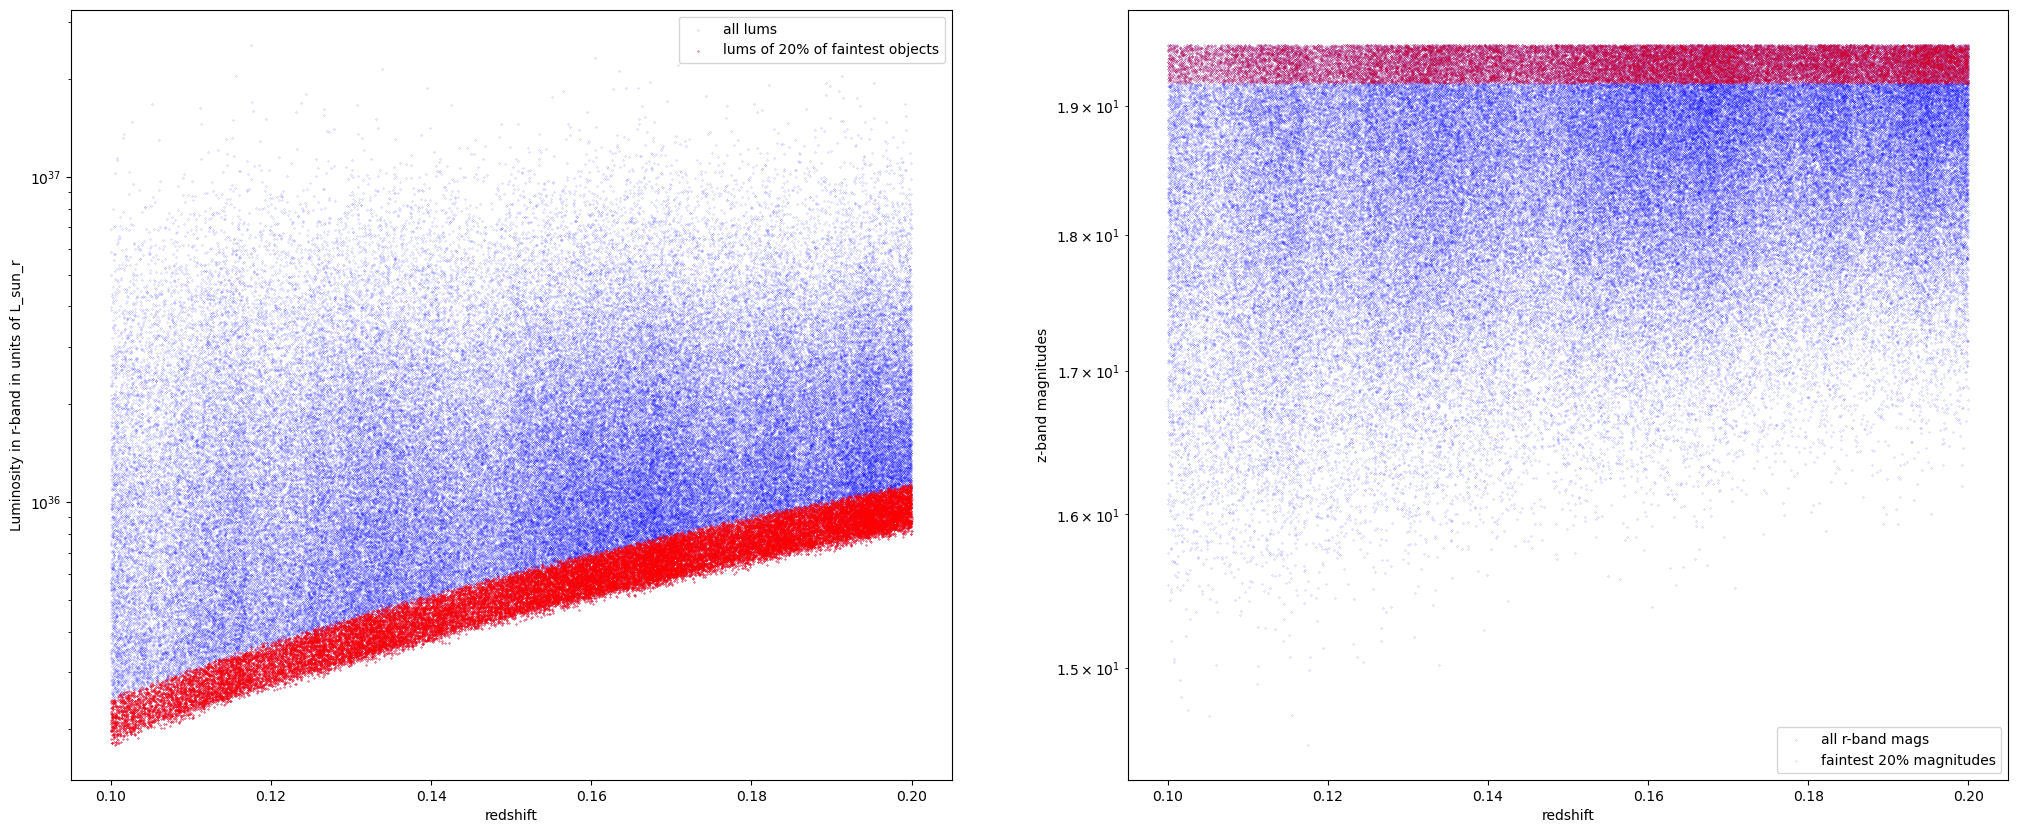

In [66]:
fig, ax = plt.subplots(ncols = 2, figsize = (25,10))

ax[0].scatter(ztile_cat_grouped_by_AppMag["Z"], ztile_cat_grouped_by_AppMag["LUM_R"], s = 0.01, color = "blue", label = "all lums")
ax[0].scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["LUM_R"], s = 0.1, color = "red", label ="lums of 20% of faintest objects")

ax[1].scatter(ztile_cat_grouped_by_AppMag["Z"], ztile_cat_grouped_by_AppMag["APP_MAG_R"], s = 0.01, color = "blue", label = "all r-band mags")
ax[1].scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["APP_MAG_R"], s = 0.01, color = "red", label = "faintest 20% magnitudes")


ax[0].set_xlabel("redshift")
ax[0].set_ylabel("Luminosity in r-band in units of L_sun_r")
ax[0].set_yscale("log")
#ax.set_xlim(0.08,.6)
#ax.set_ylim(10**3,10**5)
ax[0].legend()

ax[1].set_xlabel("redshift")
ax[1].set_ylabel("z-band magnitudes")
ax[1].set_yscale("log")
ax[1].legend()

plt.show()

In [67]:
ztile_cat_grouped_by_AppMag_sel

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,,,,,W,W,W,W
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633030595219808,249.733631644974,37.4732991549371,20230407,0.190212097732953,1.56199338241144e-05,0,8.20665836334229,15.3824548721313,23.3471660614014,GALAXY,514,0.0149062499403954,1.0,0.9562560042706568,0.9705671769012062,0.9836734791685573,20.16601955152961,19.499999875974634,19.061541975499654,-20.37281262549823,-20.82583393216498,2.4875693029707158e+36,7.602541734082257e+35,2.82211278801693e+36,7.602540865631926e+35
39633109762703891,244.161322331921,41.6303271093301,20230413,0.134936473140002,1.33186726712494e-05,0,8.08626842498779,15.5909690856934,26.2269706726074,GALAXY,514,0.00819051265716553,4.0,0.9757220597412367,0.9837188146026058,0.9909958370812224,20.203944925481743,19.49999466843444,18.94330924878598,-19.569072366759297,-20.13375991727381,1.3150600449924357e+36,3.626291478217053e+35,1.3379863106470384e+36,3.626273671162997e+35
39632936244349812,224.717818631139,32.8047872328327,20210617,0.133025712157617,6.50324250296245e-06,0,6.07890319824219,15.3306283950806,30.5596485137939,GALAXY,514,0.0166043099015951,1.81494736671448,0.9513958733216881,0.9672697558455311,0.9818306218303785,20.48634008923794,19.49996912980151,18.767220545348636,-19.51720184100469,-20.266172836231423,1.485630307212855e+36,3.457120354175166e+35,1.285231485319992e+36,3.45702206098581e+35
39633006553465242,261.054461427447,36.3126715149904,20210620,0.135741935573797,1.07250894751914e-05,0,7.22450590133667,14.4356489181519,26.1014652252197,GALAXY,514,0.0466230884194374,0.5,0.8694423511725651,0.910792118560344,0.9498161872888674,20.20108160252782,19.499957381430473,18.90243669831692,-19.499505618911584,-20.142577059410932,1.3257829813083867e+36,3.4012300720338794e+35,1.2990608863489445e+36,3.401096565649251e+35
39633030435834075,237.682160486113,37.4391214009135,20220611,0.196921017875486,1.45044040786855e-05,0,5.97568941116333,15.3868093490601,29.309850692749,GALAXY,514,0.0147932274267077,2.283198595047,0.9565803734220804,0.9707870511260926,0.9837962620696988,20.510833623130537,19.499938505434933,18.8147289050518,-20.45685489792698,-21.156517481506008,3.373250618346798e+36,8.214397633027492e+35,3.048755229420598e+36,8.21393239432351e+35
39633096122828999,243.606491187989,41.0201731749984,20230407,0.138279626857195,6.60093458752409e-06,0,9.84133625030518,15.5370311737061,21.5276794433594,GALAXY,514,0.00994677282869816,1.0,0.9705934711742449,0.9802623644257126,0.9890756901495632,19.984958237473073,19.499935729543107,19.155580774459676,-19.623019042780435,-19.9770919949175,1.1383568205758087e+36,3.811021332620024e+35,1.408293294356753e+36,3.8107957448282435e+35
39633021174809872,265.700910976159,36.969156700567,20220522,0.173815876395162,1.4096968998993e-05,0,7.55792856216431,14.9376420974731,23.9784870147705,GALAXY,514,0.0295792277902365,1.0,0.915065855137738,0.9424411491013431,0.9678628097339647,20.207623919279396,19.49993047625399,19.014980064171144,-20.124190275000437,-20.638039592634346,2.092461389694785e+36,6.046580966898279e+35,2.274216815399565e+36,6.0461937941223004e+35
39633025922764648,260.111165559501,37.2444580191916,20230407,0.134988139827934,1.25349726807455e-05,0,8.86761474609375,14.2990570068359,20.3584156036377,GALAXY,514,0.0513797178864479,0.764231622219086,0.8571206367235538,0.9021507064691104,0.9448400355898456,19.963087836851592,19.49992923990724,19.16653577836692,-19.476060089622905,-19.859651535538283,1.021650213877953e+36,3.3285707963904585e+35,1.2767296056042274e+36,3.328353872332464e+35


In [68]:
lower_limit_z = np.min(ztile_cat_grouped_by_AppMag["Z"]) # np.min(faint_mags["Z"]) # get the limits of redshift in this sample
upper_limit_z = np.max(ztile_cat_grouped_by_AppMag["Z"]) # np.max(faint_mags["Z"])
delta_z = 0.0005
bins = np.arange(lower_limit_z, upper_limit_z, delta_z)
num_of_bins_z = len(bins)

In [69]:
lower_limit_z, upper_limit_z, num_of_bins_z

(0.100001466606648, 0.199999718050522, 200)

In [70]:
LUM_95 = [0 for x in range(num_of_bins_z-1)] # this will be the array in which we store the mass limit of each bin
LUM_LIM_95 = [0 for x in range(num_of_bins_z-1)] # this will be the array in which we store the mass limit of each bin

cnt = 0
for bins_left_edge in bins[:num_of_bins_z-1]:
    # this is where we select all the galaxies that lie in the z range ([start, stop))
    
    # z-range selection
    ii = ztile_cat_grouped_by_AppMag_sel['Z']>=(bins_left_edge)
    ii &= ztile_cat_grouped_by_AppMag_sel['Z']<(bins_left_edge+delta_z)
    dat = ztile_cat_grouped_by_AppMag_sel[ii]

    # select only r-band luminosity (limit)
    LUM = dat["LUM_R"]
    LUM_LIM = dat["LUM_LIMIT_R"]
    
    # sort this data ascending
    LUM = np.sort(LUM)
    LUM_LIM = np.sort(LUM_LIM)
    
    # impose the same cut as in the paper, at 95%. This is the mass limit value
    LUM_cut = int(0.95*len(LUM))
    LUM_LIM_cut = int(0.95*len(LUM_LIM))

    # if there was no data in this bin, just store a 0
    if len(LUM) == 0:
        LUM = [0]
    if len(LUM_LIM) == 0:
        LUM_LIM = [0]
    
    # now store this luminosity (limit) value for the whole redshift range
    LUM_95[cnt] = LUM[LUM_cut] # this is the 95% lum per bin
    LUM_LIM_95[cnt] = LUM_LIM[LUM_LIM_cut] # this is the "Luminosity Limit" value per bin
    cnt += 1

In [71]:
stop_at = np.argmin(LUM_LIM_95[1:])
if stop_at == 0:
    stop_at = len(LUM_LIM_95)

In [72]:
stop_at

199

In [73]:
some_distances = np.linspace(3500*10**5,1500*10**6, 500) # distances in pc
lum_lim_from_mag_lim = gs.lum(gs.abs_mag_ldist(19.5, some_distances), band = "r")
some_z_from_dist = z_at_value(Planck18.luminosity_distance, some_distances/(10**6)*u.Mpc, zmax = 1)

Fit values:  5019814489.25751 -267526626.8173895 11858672.866716443


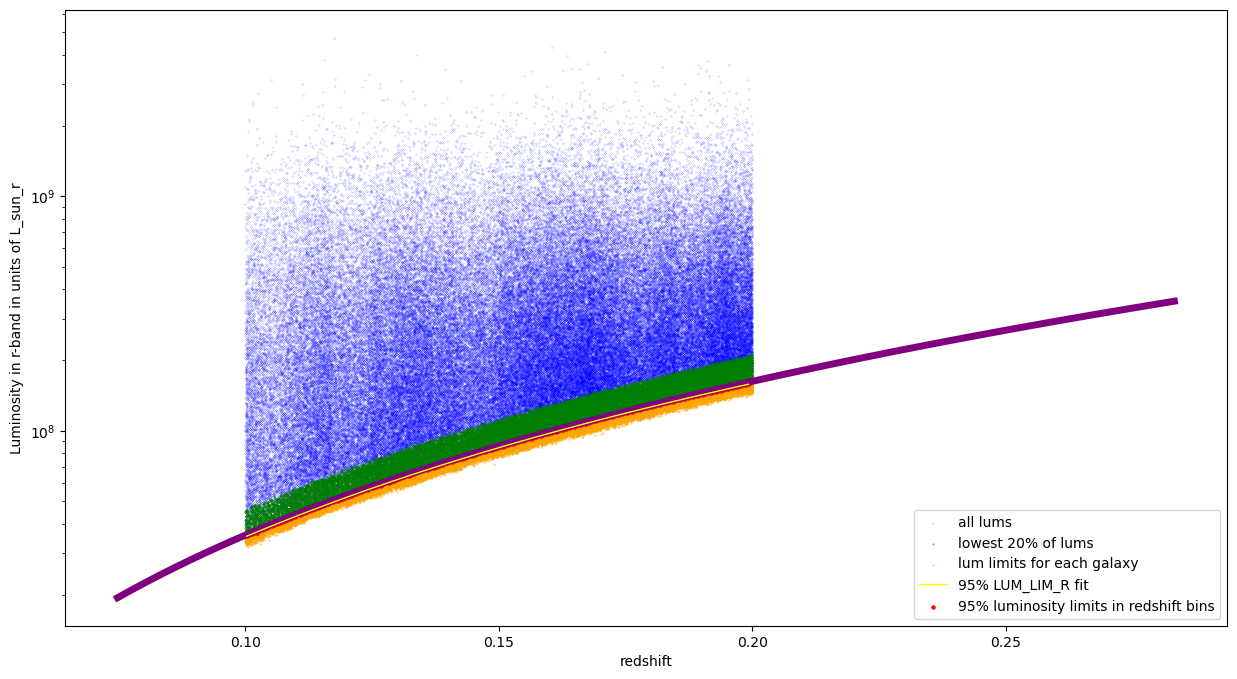

In [74]:
fig, ax = plt.subplots(figsize = (15,8))

ax.scatter(ztile_cat_grouped_by_AppMag["Z"], ztile_cat_grouped_by_AppMag["LUM_R"]/gs.L_sun_r, s = 0.01, color = "blue", label = "all lums")
ax.scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["LUM_R"]/gs.L_sun_r, s = 0.1, color = "green", label ="lowest 20% of lums")
ax.scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["LUM_LIMIT_R"]/gs.L_sun_r, s = 0.1, color = "orange", label ="lum limits for each galaxy")

ax.plot(some_z_from_dist, lum_lim_from_mag_lim/gs.L_sun_r, linewidth = 5, color = "purple")

center_z = (bins[:-1] + bins[1:])/2
#ax.scatter(center_z, LUM_95/gs.L_sun_r, s = 1, color = "orange", label = "95% cut of luminosities in redshift bin")

def poly2d(x, a, b, c):
    return a*x**2 + b*x + c

# for the fit to be good, we need to decrease the LUM values, otherwise, they fit doesn't work that well
# normalize_LUM = 10**(7)

coefs_LUM_LIM_95, _ = curve_fit(poly2d, center_z, np.array(LUM_LIM_95)/gs.L_sun_r, p0 = [7251562630.908631, -993318577.5495119, 58433580.69203088])
print("Fit values: ", coefs_LUM_LIM_95[0], coefs_LUM_LIM_95[1], coefs_LUM_LIM_95[2])

ax.plot(center_z, poly2d(center_z, *coefs_LUM_LIM_95), linewidth = 1, color = "yellow", label = "95% LUM_LIM_R fit")
#ax.plot(center_z, poly2d(center_z, *[7251562630.908631, -993318577.5495119, 58433580.69203088]), linewidth = 1, linestyle = "dashed", color = "purple", label = "old 95% LUM LIM fit")

ax.scatter(center_z, LUM_LIM_95/gs.L_sun_r, s = 5, color = "red", label ="95% luminosity limits in redshift bins")

ax.set_xlabel("redshift")
ax.set_ylabel("Luminosity in r-band in units of L_sun_r")
ax.set_yscale("log")
#ax.set_xlim(0.095, 0.6)
#ax.set_ylim(3*10**7,1*10**9)
ax.legend(loc = "lower right")
plt.show()

invert to get zmax

$$ax^2+bx+c = a(x-h)^2+k$$ with $$h = -\frac{b}{2a} \text{ and } k = c-ah^2$$

i.e. the inverse of a quadratic is:

$$ f^{-1}(x) = \pm\sqrt{\frac{x-k}{a}}+h$$

To reproduce the physically correct results one has to take the negative solution!

In [75]:
def dist_from_lum_limit(lum, m_limit):
    return np.sqrt(lum/gs.L_sun_r)*10**(0.2*m_limit_r+1)*u.Mpc/(10**6)

In [76]:
dist_from_lum_limit(10**36, 19.5), 10**36/gs.L_sun_r

(<Quantity 1081.64094436 Mpc>, 185424124.58565217)

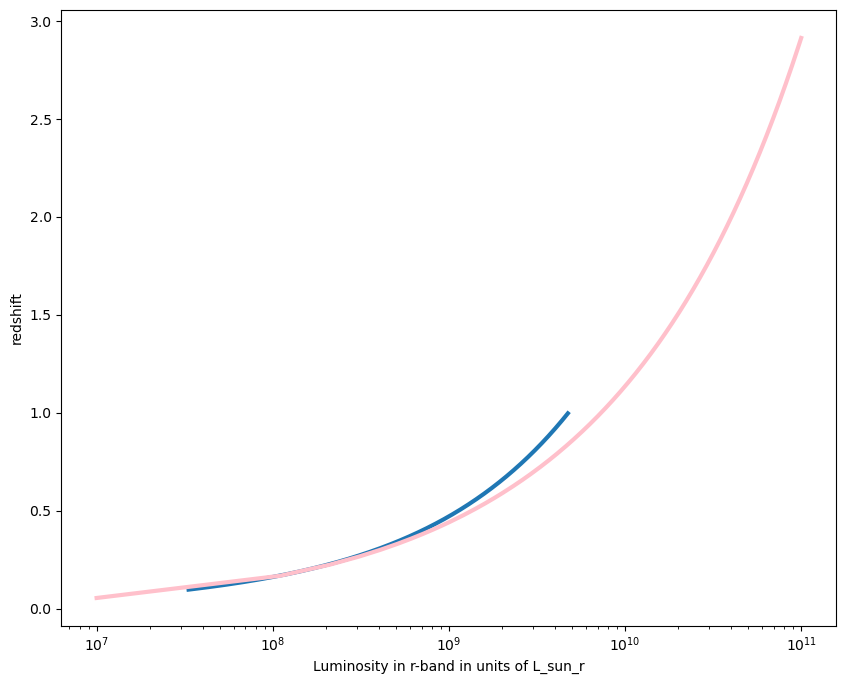

In [79]:
# now plot the inverse:

# from here we can get the z_max values, i.e. the maximum redshift at a certain luminosity that an object could be detected

# inverse is as above

def poly2d_inverse(x, a,h,k):
    return np.sqrt((x-k)/a)+h

a = coefs_LUM_LIM_95[0]
b = coefs_LUM_LIM_95[1]
c = coefs_LUM_LIM_95[2]
h = -b/(2*a)
k = c-a*h**2
inverted_coefs_95 = [a,h,k]

fig, ax = plt.subplots(figsize = (10,8))

#ax.scatter(LUM_LIM_95, center_z, s = 3, color = "red", label ="Calculated luminosity limits, including a offseted z-band magnitude limit")

lum_bins_plot = np.logspace(np.log10(np.min(ztile_cat_grouped_by_AppMag["LUM_R"])), np.log10(np.max(ztile_cat_grouped_by_AppMag["LUM_R"])), 1000, endpoint = True)

ax.plot(lum_bins_plot/gs.L_sun_r, poly2d_inverse(lum_bins_plot/gs.L_sun_r, *inverted_coefs_95), linewidth = 3)

# derived a theoretical expression for this (see notability)
some_lums_r = np.linspace(10**7*gs.L_sun_r, 10**11*gs.L_sun_r, 1000)
d_pc = dist_from_lum_limit(some_lums_r, m_limit_r)
z_from_some_lums_r = z_at_value(Planck18.luminosity_distance, d_pc, zmin= 0.01, zmax = 6)

ax.plot(some_lums_r/gs.L_sun_r, z_from_some_lums_r, linewidth = 3, color = "pink")
#ax.plot(lum_lim_from_mag_lim/gs.L_sun_r, some_z_from_dist, linewidth = 3, color = "purple")


#ax.vlines(LUM_LIM_95[stop_at-1], 0, 1, label = "limit of fit")


ax.set_xlabel("Luminosity in r-band in units of L_sun_r")
ax.set_ylabel("redshift")
ax.set_xscale("log")
#ax.set_ylim(0,1)
#ax.set_xlim(10,10**5)
#ax.legend()
plt.show()

In [80]:
m_limit_r

19.5

In [81]:
ztile_cat_grouped_by_AppMag[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,,,,,W,W,W,W
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633030595219808,249.733631644974,37.4732991549371,20230407,0.190212097732953,1.56199338241144e-05,0,8.20665836334229,15.3824548721313,23.3471660614014,GALAXY,514,0.0149062499403954,1.0,0.9562560042706568,0.9705671769012062,0.9836734791685573,20.16601955152961,19.499999875974634,19.061541975499654,-20.37281262549823,-20.82583393216498,2.4875693029707158e+36,7.602541734082257e+35,2.82211278801693e+36,7.602540865631926e+35
39633109762703891,244.161322331921,41.6303271093301,20230413,0.134936473140002,1.33186726712494e-05,0,8.08626842498779,15.5909690856934,26.2269706726074,GALAXY,514,0.00819051265716553,4.0,0.9757220597412367,0.9837188146026058,0.9909958370812224,20.203944925481743,19.49999466843444,18.94330924878598,-19.569072366759297,-20.13375991727381,1.3150600449924357e+36,3.626291478217053e+35,1.3379863106470384e+36,3.626273671162997e+35
39632936244349812,224.717818631139,32.8047872328327,20210617,0.133025712157617,6.50324250296245e-06,0,6.07890319824219,15.3306283950806,30.5596485137939,GALAXY,514,0.0166043099015951,1.81494736671448,0.9513958733216881,0.9672697558455311,0.9818306218303785,20.48634008923794,19.49996912980151,18.767220545348636,-19.51720184100469,-20.266172836231423,1.485630307212855e+36,3.457120354175166e+35,1.285231485319992e+36,3.45702206098581e+35
39633006553465242,261.054461427447,36.3126715149904,20210620,0.135741935573797,1.07250894751914e-05,0,7.22450590133667,14.4356489181519,26.1014652252197,GALAXY,514,0.0466230884194374,0.5,0.8694423511725651,0.910792118560344,0.9498161872888674,20.20108160252782,19.499957381430473,18.90243669831692,-19.499505618911584,-20.142577059410932,1.3257829813083867e+36,3.4012300720338794e+35,1.2990608863489445e+36,3.401096565649251e+35
39633030435834075,237.682160486113,37.4391214009135,20220611,0.196921017875486,1.45044040786855e-05,0,5.97568941116333,15.3868093490601,29.309850692749,GALAXY,514,0.0147932274267077,2.283198595047,0.9565803734220804,0.9707870511260926,0.9837962620696988,20.510833623130537,19.499938505434933,18.8147289050518,-20.45685489792698,-21.156517481506008,3.373250618346798e+36,8.214397633027492e+35,3.048755229420598e+36,8.21393239432351e+35


In [82]:
np.max(ztile_cat_grouped_by_AppMag["ABS_MAG_R"]), np.min(ztile_cat_grouped_by_AppMag["ABS_MAG_R"])

(-18.805348083522265, -24.188233492848724)

In [96]:
z_max_i = np.array(poly2d_inverse(ztile_cat_grouped_by_AppMag["LUM_R"]/gs.L_sun_r, *inverted_coefs_95))

dist_max_i = dist_from_lum_limit(ztile_cat_grouped_by_AppMag["LUM_R"], m_limit_r)/u.W

In [97]:
np.min(z_max_i), np.mean(z_max_i), np.max(z_max_i), np.median(z_max_i)
np.min(dist_max_i), np.mean(dist_max_i), np.max(dist_max_i), np.median(dist_max_i)

(<Quantity 458.21533201 Mpc>,
 <Quantity 1246.6188315 Mpc>,
 <Quantity 5465.71142751 Mpc>,
 <Quantity 1123.43200685 Mpc>)

In [98]:
dist_max_i

<Quantity [ 943.11038069,  651.35008379,  635.97547477, ..., 4899.97694361,
           4437.81647694, 5465.71142751] Mpc>

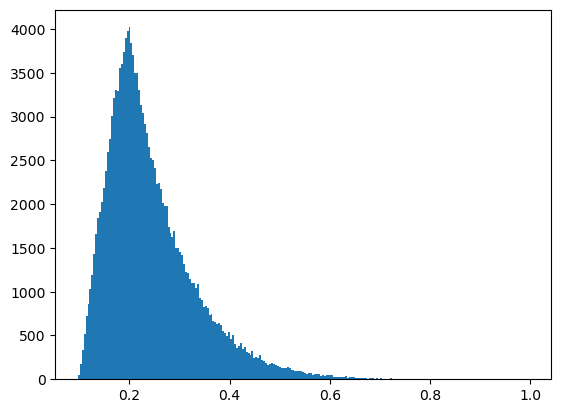

In [99]:
plt.hist(z_max_i, bins = "auto")
plt.show()

In [100]:
z_max_i[:5], len(ztile_cat_grouped_by_AppMag)

(array([0.18922104, 0.13501057, 0.13208784, 0.13110427, 0.19602946]), 154636)

In [101]:
ztile_cat_z_max = 5

In [102]:
ztile_cat_z_max = hstack([ztile_cat_grouped_by_AppMag, Table({"z_max": z_max_i}), Table({"dist_max": dist_max_i})])

In [103]:
ztile_cat_z_max[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R,z_max,dist_max
,,,,,,,,,,,,,,,,,,,,,,W,W,W,W,,Mpc
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633030595219808,249.733631644974,37.4732991549371,20230407,0.190212097732953,1.56199338241144e-05,0,8.20665836334229,15.3824548721313,23.3471660614014,GALAXY,514,0.0149062499403954,1.0,0.9562560042706568,0.9705671769012062,0.9836734791685573,20.16601955152961,19.499999875974634,19.061541975499654,-20.37281262549823,-20.82583393216498,2.4875693029707158e+36,7.602541734082257e+35,2.82211278801693e+36,7.602540865631926e+35,0.18922103905616353,943.1103806865267
39633109762703891,244.161322331921,41.6303271093301,20230413,0.134936473140002,1.33186726712494e-05,0,8.08626842498779,15.5909690856934,26.2269706726074,GALAXY,514,0.00819051265716553,4.0,0.9757220597412367,0.9837188146026058,0.9909958370812224,20.203944925481743,19.49999466843444,18.94330924878598,-19.569072366759297,-20.13375991727381,1.3150600449924357e+36,3.626291478217053e+35,1.3379863106470384e+36,3.626273671162997e+35,0.13501056643178136,651.350083794431
39632936244349812,224.717818631139,32.8047872328327,20210617,0.133025712157617,6.50324250296245e-06,0,6.07890319824219,15.3306283950806,30.5596485137939,GALAXY,514,0.0166043099015951,1.81494736671448,0.9513958733216881,0.9672697558455311,0.9818306218303785,20.48634008923794,19.49996912980151,18.767220545348636,-19.51720184100469,-20.266172836231423,1.485630307212855e+36,3.457120354175166e+35,1.285231485319992e+36,3.45702206098581e+35,0.1320878383485601,635.9754747719136
39633006553465242,261.054461427447,36.3126715149904,20210620,0.135741935573797,1.07250894751914e-05,0,7.22450590133667,14.4356489181519,26.1014652252197,GALAXY,514,0.0466230884194374,0.5,0.8694423511725651,0.910792118560344,0.9498161872888674,20.20108160252782,19.499957381430473,18.90243669831692,-19.499505618911584,-20.142577059410932,1.3257829813083867e+36,3.4012300720338794e+35,1.2990608863489445e+36,3.401096565649251e+35,0.13110426530495017,630.8137102019235
39633030435834075,237.682160486113,37.4391214009135,20220611,0.196921017875486,1.45044040786855e-05,0,5.97568941116333,15.3868093490601,29.309850692749,GALAXY,514,0.0147932274267077,2.283198595047,0.9565803734220804,0.9707870511260926,0.9837962620696988,20.510833623130537,19.499938505434933,18.8147289050518,-20.45685489792698,-21.156517481506008,3.373250618346798e+36,8.214397633027492e+35,3.048755229420598e+36,8.21393239432351e+35,0.1960294647832798,980.3270350280022


In [104]:
#only allow redshifts above 0.1
#ztile_cat_z_max = ztile_cat_z_max[ztile_cat_z_max["z_max"] > 0.1]

In [105]:
ztile_cat_z_max[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R,z_max,dist_max
,,,,,,,,,,,,,,,,,,,,,,W,W,W,W,,Mpc
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633030595219808,249.733631644974,37.4732991549371,20230407,0.190212097732953,1.56199338241144e-05,0,8.20665836334229,15.3824548721313,23.3471660614014,GALAXY,514,0.0149062499403954,1.0,0.9562560042706568,0.9705671769012062,0.9836734791685573,20.16601955152961,19.499999875974634,19.061541975499654,-20.37281262549823,-20.82583393216498,2.4875693029707158e+36,7.602541734082257e+35,2.82211278801693e+36,7.602540865631926e+35,0.18922103905616353,943.1103806865267
39633109762703891,244.161322331921,41.6303271093301,20230413,0.134936473140002,1.33186726712494e-05,0,8.08626842498779,15.5909690856934,26.2269706726074,GALAXY,514,0.00819051265716553,4.0,0.9757220597412367,0.9837188146026058,0.9909958370812224,20.203944925481743,19.49999466843444,18.94330924878598,-19.569072366759297,-20.13375991727381,1.3150600449924357e+36,3.626291478217053e+35,1.3379863106470384e+36,3.626273671162997e+35,0.13501056643178136,651.350083794431
39632936244349812,224.717818631139,32.8047872328327,20210617,0.133025712157617,6.50324250296245e-06,0,6.07890319824219,15.3306283950806,30.5596485137939,GALAXY,514,0.0166043099015951,1.81494736671448,0.9513958733216881,0.9672697558455311,0.9818306218303785,20.48634008923794,19.49996912980151,18.767220545348636,-19.51720184100469,-20.266172836231423,1.485630307212855e+36,3.457120354175166e+35,1.285231485319992e+36,3.45702206098581e+35,0.1320878383485601,635.9754747719136
39633006553465242,261.054461427447,36.3126715149904,20210620,0.135741935573797,1.07250894751914e-05,0,7.22450590133667,14.4356489181519,26.1014652252197,GALAXY,514,0.0466230884194374,0.5,0.8694423511725651,0.910792118560344,0.9498161872888674,20.20108160252782,19.499957381430473,18.90243669831692,-19.499505618911584,-20.142577059410932,1.3257829813083867e+36,3.4012300720338794e+35,1.2990608863489445e+36,3.401096565649251e+35,0.13110426530495017,630.8137102019235
39633030435834075,237.682160486113,37.4391214009135,20220611,0.196921017875486,1.45044040786855e-05,0,5.97568941116333,15.3868093490601,29.309850692749,GALAXY,514,0.0147932274267077,2.283198595047,0.9565803734220804,0.9707870511260926,0.9837962620696988,20.510833623130537,19.499938505434933,18.8147289050518,-20.45685489792698,-21.156517481506008,3.373250618346798e+36,8.214397633027492e+35,3.048755229420598e+36,8.21393239432351e+35,0.1960294647832798,980.3270350280022


In [106]:
np.min(ztile_cat_z_max["Z"]), np.max(ztile_cat_z_max["Z"])

(0.100001466606648, 0.199999718050522)

In [113]:
dist_min, dist_max_data = Distance(z = np.min(ztile_cat_z_max["Z"]), cosmology = Planck18), Distance(z = np.max(ztile_cat_z_max["Z"]), cosmology = Planck18)

In [114]:
dist_min, dist_max_data

(<Distance 475.82970816 Mpc>, <Distance 1012.29188784 Mpc>)

In [107]:
 z_min_data, z_max_data

(0.100001466606648, 0.199999718050522)

In [115]:
V_max_i = gs.V_max(area, z_min_data, z_max_data, ztile_cat_z_max["z_max"])
V_max_dist_i = gs.V_max_dist(area, dist_min, dist_max_data, ztile_cat_z_max["dist_max"])

In [116]:
len(V_max_i)

154636

In [117]:
len(ztile_cat_z_max)

154636

In [118]:
V_max_i[:5]

<Quantity [31208106.44562861,  8176884.07323506,  7314292.91498912,
            7031879.48720295, 35138696.36612391] Mpc3>

In [119]:
ztile_wVmax = hstack([ztile_cat_z_max, Table({"V_MAX": V_max_i}), Table({"V_MAX_DIST": V_max_dist_i})])

In [120]:
ztile_wVmax

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R,z_max,dist_max,V_MAX,V_MAX_DIST
,,,,,,,,,,,,,,,,,,,,,,W,W,W,W,,Mpc,Mpc3,Mpc3
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633030595219808,249.733631644974,37.4732991549371,20230407,0.190212097732953,1.56199338241144e-05,0,8.20665836334229,15.3824548721313,23.3471660614014,GALAXY,514,0.0149062499403954,1.0,0.9562560042706568,0.9705671769012062,0.9836734791685573,20.16601955152961,19.499999875974634,19.061541975499654,-20.37281262549823,-20.82583393216498,2.4875693029707158e+36,7.602541734082257e+35,2.82211278801693e+36,7.602540865631926e+35,0.18922103905616353,943.1103806865267,31208106.44562861,52855603.25946909
39633109762703891,244.161322331921,41.6303271093301,20230413,0.134936473140002,1.33186726712494e-05,0,8.08626842498779,15.5909690856934,26.2269706726074,GALAXY,514,0.00819051265716553,4.0,0.9757220597412367,0.9837188146026058,0.9909958370812224,20.203944925481743,19.49999466843444,18.94330924878598,-19.569072366759297,-20.13375991727381,1.3150600449924357e+36,3.626291478217053e+35,1.3379863106470384e+36,3.626273671162997e+35,0.13501056643178136,651.350083794431,8176884.073235055,12189125.682258224
39632936244349812,224.717818631139,32.8047872328327,20210617,0.133025712157617,6.50324250296245e-06,0,6.07890319824219,15.3306283950806,30.5596485137939,GALAXY,514,0.0166043099015951,1.81494736671448,0.9513958733216881,0.9672697558455311,0.9818306218303785,20.48634008923794,19.49996912980151,18.767220545348636,-19.51720184100469,-20.266172836231423,1.485630307212855e+36,3.457120354175166e+35,1.285231485319992e+36,3.45702206098581e+35,0.1320878383485601,635.9754747719136,7314292.914989118,10807583.816765178
39633006553465242,261.054461427447,36.3126715149904,20210620,0.135741935573797,1.07250894751914e-05,0,7.22450590133667,14.4356489181519,26.1014652252197,GALAXY,514,0.0466230884194374,0.5,0.8694423511725651,0.910792118560344,0.9498161872888674,20.20108160252782,19.499957381430473,18.90243669831692,-19.499505618911584,-20.142577059410932,1.3257829813083867e+36,3.4012300720338794e+35,1.2990608863489445e+36,3.401096565649251e+35,0.13110426530495017,630.8137102019235,7031879.4872029545,10358454.062429585
39633030435834075,237.682160486113,37.4391214009135,20220611,0.196921017875486,1.45044040786855e-05,0,5.97568941116333,15.3868093490601,29.309850692749,GALAXY,514,0.0147932274267077,2.283198595047,0.9565803734220804,0.9707870511260926,0.9837962620696988,20.510833623130537,19.499938505434933,18.8147289050518,-20.45685489792698,-21.156517481506008,3.373250618346798e+36,8.214397633027492e+35,3.048755229420598e+36,8.21393239432351e+35,0.1960294647832798,980.3270350280022,35138696.36612391,60321984.82927526
39633096122828999,243.606491187989,41.0201731749984,20230407,0.138279626857195,6.60093458752409e-06,0,9.84133625030518,15.5370311737061,21.5276794433594,GALAXY,514,0.00994677282869816,1.0,0.9705934711742449,0.9802623644257126,0.9890756901495632,19.984958237473073,19.499935729543107,19.155580774459676,-19.623019042780435,-19.9770919949175,1.1383568205758087e+36,3.811021332620024e+35,1.408293294356753e+36,3.8107957448282435e+35,0.1381146016437705,667.7344891525452,9131833.7431026,13734952.502963047
39633021174809872,265.700910976159,36.969156700567,20220522,0.173815876395162,1.4096968998993e-05,0,7.55792856216431,14.9376420974731,23.9784870147705,GALAXY,514,0.0295792277902365,1.0,0.915065855137738,0.9424411491013431,0.9678628097339647,20.207623919279396,19.49993047625399,19.014980064171144,-20.124190275000437,-20.638039592634346,2.092461389694785e+36,6.046580966898279e+35,2.274216815399565e+36,6.046193794122

In [121]:
lower_limit_lum = np.min(ztile_wVmax["LUM_R"])
upper_limit_lum = np.max(ztile_wVmax["LUM_R"])
print("lower and upper limit of LUM_R: ", lower_limit_lum, upper_limit_lum)

num_of_lum_bins = 100

lum_bins = np.logspace(np.log10(lower_limit_lum), np.log10(upper_limit_lum), num_of_lum_bins, endpoint = True)

print("num of bins", len(lum_bins))
print(lum_bins[0:10])

lower and upper limit of LUM_R:  1.7946220359086366e+35 2.553448833595504e+37
num of bins 100
[1.79462204e+35 1.88678332e+35 1.98367747e+35 2.08554753e+35
 2.19264904e+35 2.30525066e+35 2.42363485e+35 2.54809854e+35
 2.67895397e+35 2.81652937e+35]


In [122]:
len(lum_bins)

100

In [123]:
def calc_phi_j(V_max_i, lum_bins, w_spec = 1):
    
    phi_j = [0 for q in range(len(lum_bins)-1)]
    cnt = 0
    for q in range(len(phi_j)):
        
        ii = ztile_wVmax["LUM_R"] >= lum_bins[q]
        ii &= ztile_wVmax["LUM_R"]< lum_bins[q+1]
        dat = ztile_wVmax[ii]
        #print("Num of objects in this bin", len(dat))
        dat = dat["V_MAX"]
        one_ov_dat = [w_spec/vmax for vmax in dat]
        phi_j[cnt] = np.sum(one_ov_dat)
        cnt += 1
    return phi_j

def calc_phi_j_dist(V_max_i, lum_bins, w_spec = 1):
    
    phi_j = [0 for q in range(len(lum_bins)-1)]
    cnt = 0
    for q in range(len(phi_j)):
        
        ii = ztile_wVmax["LUM_R"] >= lum_bins[q]
        ii &= ztile_wVmax["LUM_R"]< lum_bins[q+1]
        dat = ztile_wVmax[ii]
        #print("Num of objects in this bin", len(dat))
        dat = dat["V_MAX_DIST"]
        one_ov_dat = [w_spec/vmax for vmax in dat]
        phi_j[cnt] = np.sum(one_ov_dat)
        cnt += 1
    return phi_j

In [124]:
phi_j = calc_phi_j(V_max_i, lum_bins)
phi_j_dist = calc_phi_j_dist(V_max_dist_i, lum_bins)

In [125]:
len(phi_j)

99

In [126]:
phi_j[:5]

[-6.900606335369052e-05,
 0.000448572930319327,
 0.00020392497319411795,
 0.00018024800044002466,
 0.00017763423784693494]

In [127]:
center_lum_bins = lum_bins[1:]-(lum_bins[2]-lum_bins[1])/2

In [128]:
len(center_lum_bins)

99

In [129]:
center_lum_bins

array([1.83833625e+35, 1.93523039e+35, 2.03710046e+35, 2.14420197e+35,
       2.25680359e+35, 2.37518777e+35, 2.49965147e+35, 2.63050690e+35,
       2.76808229e+35, 2.91272275e+35, 3.06479110e+35, 3.22466879e+35,
       3.39275687e+35, 3.56947696e+35, 3.75527236e+35, 3.95060913e+35,
       4.15597724e+35, 4.37189187e+35, 4.59889460e+35, 4.83755487e+35,
       5.08847133e+35, 5.35227339e+35, 5.62962278e+35, 5.92121521e+35,
       6.22778213e+35, 6.55009252e+35, 6.88895489e+35, 7.24521925e+35,
       7.61977926e+35, 8.01357448e+35, 8.42759272e+35, 8.86287251e+35,
       9.32050572e+35, 9.80164029e+35, 1.03074831e+36, 1.08393031e+36,
       1.13984342e+36, 1.19862790e+36, 1.26043121e+36, 1.32540838e+36,
       1.39372239e+36, 1.46554461e+36, 1.54105520e+36, 1.62044357e+36,
       1.70390886e+36, 1.79166044e+36, 1.88391843e+36, 1.98091425e+36,
       2.08289121e+36, 2.19010510e+36, 2.30282488e+36, 2.42133328e+36,
       2.54592758e+36, 2.67692031e+36, 2.81464007e+36, 2.95943230e+36,
      

In [130]:
np.diff(lum_bins)

array([9.21612833e+33, 9.68941473e+33, 1.01870064e+34, 1.07101514e+34,
       1.12601621e+34, 1.18384181e+34, 1.24463699e+34, 1.30855426e+34,
       1.37575395e+34, 1.44640462e+34, 1.52068350e+34, 1.59877690e+34,
       1.68088072e+34, 1.76720092e+34, 1.85795401e+34, 1.95336766e+34,
       2.05368119e+34, 2.15914623e+34, 2.27002734e+34, 2.38660266e+34,
       2.50916460e+34, 2.63802061e+34, 2.77349391e+34, 2.91592432e+34,
       3.06566913e+34, 3.22310395e+34, 3.38862370e+34, 3.56264358e+34,
       3.74560010e+34, 3.93795220e+34, 4.14018237e+34, 4.35279791e+34,
       4.57633213e+34, 4.81134576e+34, 5.05842832e+34, 5.31819958e+34,
       5.59131119e+34, 5.87844820e+34, 6.18033089e+34, 6.49771651e+34,
       6.83140120e+34, 7.18222198e+34, 7.55105886e+34, 7.93883704e+34,
       8.34652924e+34, 8.77515813e+34, 9.22579889e+34, 9.69958192e+34,
       1.01976957e+35, 1.07213896e+35, 1.12719774e+35, 1.18508402e+35,
       1.24594300e+35, 1.30992734e+35, 1.37719754e+35, 1.44792235e+35,
      

### Lets now also compare this to our original density

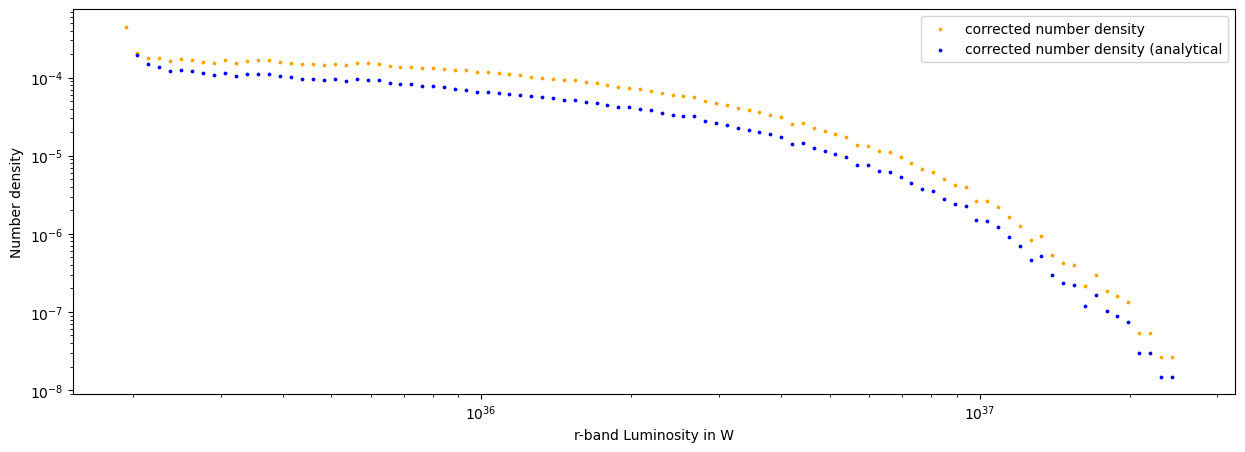

In [131]:
fig, ax = plt.subplots(figsize = (15,5))

ax.scatter(center_lum_bins[1:], phi_j[1:], s = 3, color = "orange", label = "corrected number density")
ax.scatter(center_lum_bins[1:], phi_j_dist[1:], s = 3, color = "blue", label = "corrected number density (analytical)")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("r-band Luminosity in W")
ax.set_ylabel("Number density")

plt.legend(loc = "upper right")
#plt.savefig("NumberDensity-1_overVmax.png", dpi = 300, transparent = True)

plt.show()

In [132]:
def schechter_lum(L, phi_star, L_star, alpha):
    return phi_star*(L/L_star)**(alpha)*np.exp(-L/L_star)

In [133]:
"""coefs_lum_fit, _ = curve_fit(schechter_lum, center_lum_bins[0:]/gs.L_sun_r, phi_j[0:], p0 = [30/(10**6), 2.5*10**8, -0.5])
print(coefs_lum_fit)"""

'coefs_lum_fit, _ = curve_fit(schechter_lum, center_lum_bins[0:]/gs.L_sun_r, phi_j[0:], p0 = [30/(10**6), 2.5*10**8, -0.5])\nprint(coefs_lum_fit)'

In [134]:
"""fig, ax = plt.subplots(figsize = (15,5))

some_bins = np.logspace(np.log10(lower_limit_lum), np.log10(upper_limit_lum), 1000, endpoint = True)


ax.plot(some_bins/gs.L_sun_r, schechter_lum(some_bins/gs.L_sun_r, 30/(10**6), 2.5*10**8, -0.5), linewidth = 2, alpha = 0.5, color = "orange", label = "some plot")
ax.scatter(center_lum_bins/gs.L_sun_r, phi_j, s = 3, color = "blue", label = "corrected number density, rescaled")
ax.plot(center_lum_bins/gs.L_sun_r, schechter_lum(center_lum_bins/gs.L_sun_r, *coefs_lum_fit), linewidth = 3, color = "green", label = "corrected number density, rescaled")

smodel = Model(schechter_lum)
result = smodel.fit(phi_j[0:], L = center_lum_bins[0:]/gs.L_sun_r, phi_star = 30/(10**6), L_star = 2.5*10**8, alpha = -0.5)
ax.plot(center_lum_bins/gs.L_sun_r, result.best_fit, "--", linewidth = 3, color = "red", label = "lmfit")
ax.plot(center_lum_bins/gs.L_sun_r, result.init_fit, "--", linewidth = 1, color = "black", label = "lmfit start")


ax.set_xscale("log")
ax.set_yscale("log")

#ax.set_xlabel("r-band Luminosity in W")
ax.set_ylabel("Number density")
#ax.set_ylim(10**-8, 10**-3)
plt.legend(loc = "lower left")
#plt.savefig("NumberDensity-1_overVmax.png", dpi = 300, transparent = True)

plt.show()"""

'fig, ax = plt.subplots(figsize = (15,5))\n\nsome_bins = np.logspace(np.log10(lower_limit_lum), np.log10(upper_limit_lum), 1000, endpoint = True)\n\n\nax.plot(some_bins/gs.L_sun_r, schechter_lum(some_bins/gs.L_sun_r, 30/(10**6), 2.5*10**8, -0.5), linewidth = 2, alpha = 0.5, color = "orange", label = "some plot")\nax.scatter(center_lum_bins/gs.L_sun_r, phi_j, s = 3, color = "blue", label = "corrected number density, rescaled")\nax.plot(center_lum_bins/gs.L_sun_r, schechter_lum(center_lum_bins/gs.L_sun_r, *coefs_lum_fit), linewidth = 3, color = "green", label = "corrected number density, rescaled")\n\nsmodel = Model(schechter_lum)\nresult = smodel.fit(phi_j[0:], L = center_lum_bins[0:]/gs.L_sun_r, phi_star = 30/(10**6), L_star = 2.5*10**8, alpha = -0.5)\nax.plot(center_lum_bins/gs.L_sun_r, result.best_fit, "--", linewidth = 3, color = "red", label = "lmfit")\nax.plot(center_lum_bins/gs.L_sun_r, result.init_fit, "--", linewidth = 1, color = "black", label = "lmfit start")\n\n\nax.set_xsca

In [135]:
def calc_tot_num(lum_bins):
    
    tot_num = [0 for q in range(len(lum_bins)-1)]
    cnt = 0
    for q in range(len(tot_num)):
        
        ii = ztile_wVmax["LUM_R"] >= lum_bins[q]
        ii &= ztile_wVmax["LUM_R"]< lum_bins[q+1]
        dat = ztile_wVmax[ii]
        #print("Num of objects in this bin", len(dat))
        
        tot_num[cnt] = len(dat)
        cnt += 1
    return tot_num

In [136]:
"""fig, ax = plt.subplots(figsize = (15,5))

#tot_num = calc_tot_num(lum_bins)

ax.scatter(center_lum_bins[1:], phi_j[1:]*110000000, s = 3, color = "orange", label = "corrected number density")

#ax.scatter(center_lum_bins, tot_num, s = 3, label = "uncorrected number density")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("r-band Luminosity in W")
ax.set_ylabel("Number density")
plt.legend(loc = "lower left")
#plt.savefig("NumberDensity-total.png", dpi = 300, transparent = True)
plt.show()"""

'fig, ax = plt.subplots(figsize = (15,5))\n\n#tot_num = calc_tot_num(lum_bins)\n\nax.scatter(center_lum_bins[1:], phi_j[1:]*110000000, s = 3, color = "orange", label = "corrected number density")\n\n#ax.scatter(center_lum_bins, tot_num, s = 3, label = "uncorrected number density")\n\nax.set_xscale("log")\nax.set_yscale("log")\n\nax.set_xlabel("r-band Luminosity in W")\nax.set_ylabel("Number density")\nplt.legend(loc = "lower left")\n#plt.savefig("NumberDensity-total.png", dpi = 300, transparent = True)\nplt.show()'

In [137]:
# Fit a schechter function to the data
# for this we need to go from the Luminosities back to the magnitudes...

In [138]:
len(center_lum_bins), len(phi_j)

(99, 99)

In [139]:
phi_j = np.array(phi_j)

In [140]:
mag_bins = gs.M(lum_bins*u.W, band = "r")

In [141]:
mag_bins_center = mag_bins[1:]-(mag_bins[1]-mag_bins[0])/2

In [142]:
mag_bins_width_i = np.diff(mag_bins)

In [143]:
if np.all(np.isclose(mag_bins_width_i, mag_bins_width_i[0])):
    mag_bins_width = abs(np.mean(mag_bins_width_i))
else:
    print("ERROR; BIN WIDTH for absolute MAGNITUDES is not equal!")
    print("Will continue with just a mean bin width, this is not good though")
    mag_bins_width = abs(np.mean(mag_bins_width_i))

In [144]:
mag_bins_width

<Quantity 0.05437258>

In [145]:
phi_j.shape, mag_bins_center.shape

((99,), (99,))

In [146]:
phi_j, mag_bins_center

(array([-6.90060634e-05,  4.48572930e-04,  2.03924973e-04,  1.80248000e-04,
         1.77634238e-04,  1.63023312e-04,  1.70434088e-04,  1.69527324e-04,
         1.59008624e-04,  1.52929245e-04,  1.66591322e-04,  1.52259200e-04,
         1.61419832e-04,  1.65430005e-04,  1.67578730e-04,  1.56610908e-04,
         1.54619500e-04,  1.47683876e-04,  1.47187133e-04,  1.45085992e-04,
         1.50606646e-04,  1.43045905e-04,  1.52167343e-04,  1.51713488e-04,
         1.49877954e-04,  1.41837573e-04,  1.38406977e-04,  1.37281793e-04,
         1.33269503e-04,  1.33860413e-04,  1.29101955e-04,  1.25708294e-04,
         1.23232482e-04,  1.17852546e-04,  1.17719380e-04,  1.13111811e-04,
         1.10395210e-04,  1.06453475e-04,  1.02458474e-04,  9.96353392e-05,
         9.67589380e-05,  9.22046362e-05,  9.17252361e-05,  8.74905344e-05,
         8.52000668e-05,  7.92341978e-05,  7.49462295e-05,  7.44668293e-05,
         7.16436948e-05,  6.79150267e-05,  6.29878581e-05,  6.01380903e-05,
         5.7

In [147]:
fit_data = hstack([Table({"LUM": center_lum_bins}), Table({"ABS_MAG_R": mag_bins_center}), Table({"N": phi_j}), Table({"N_dist": phi_j_dist})])

In [148]:
mag_bins_min = np.min(mag_bins)
mag_bins_max = np.max(mag_bins)
mag_bins_scaled = np.arange(mag_bins_min, mag_bins_max, 0.5)
mag_bins_center_scaled = mag_bins_scaled[1:]-(mag_bins_scaled[1]-mag_bins_scaled[0])/2

lum_bins_scaled = gs.lum(mag_bins_scaled, band = "r")
lum_bins_center_scaled = lum_bins_scaled[1:]-(lum_bins_scaled[1]-lum_bins_scaled[0])/2


In [149]:
mag_bins_scaled, len(mag_bins_scaled), mag_bins_center_scaled, len(mag_bins_center_scaled)

(array([-24.18823349, -23.68823349, -23.18823349, -22.68823349,
        -22.18823349, -21.68823349, -21.18823349, -20.68823349,
        -20.18823349, -19.68823349, -19.18823349]),
 11,
 array([-23.93823349, -23.43823349, -22.93823349, -22.43823349,
        -21.93823349, -21.43823349, -20.93823349, -20.43823349,
        -19.93823349, -19.43823349]),
 10)

In [177]:
mag_bins_center_scaled_length = len(mag_bins_center_scaled)
phi_j_length = len(phi_j)
phi_j_step_size_scaled = phi_j_length/mag_bins_center_scaled_length
print("phi_j_step_size_scaled: ", phi_j_step_size_scaled)
phi_j_step_size_scaled = int(phi_j_step_size_scaled)
phi_j_scaled = []
phi_j_dist_scaled = []
for q in range(mag_bins_center_scaled_length):
    phi_j_scaled.append(np.sum(phi_j[q*phi_j_step_size_scaled:(q+1)*phi_j_step_size_scaled]))
    phi_j_dist_scaled.append(np.sum(phi_j_dist[q*phi_j_step_size_scaled:(q+1)*phi_j_step_size_scaled]))
    
phi_j_scaled = phi_j_scaled[::-1]
phi_j_dist_scaled = phi_j_dist_scaled[::-1]

phi_j_step_size_scaled:  9.9


In [151]:
phi_j_scaled, len(phi_j_scaled)

([8.389503297793735e-06,
  4.9271686034661625e-05,
  0.00015519249433728285,
  0.00034740533656006824,
  0.0006057221381007078,
  0.000872321909563931,
  0.0011311381765250535,
  0.001319929009891533,
  0.0014251226181539887,
  0.001603367426869788],
 10)

In [180]:
fit_data_scaled = hstack([Table({"LUM_center_sc": lum_bins_center_scaled}), Table({"ABS_MAG_R_center_sc": mag_bins_center_scaled}), Table({"N_sc": phi_j_scaled}), Table({"N_dist_sc": phi_j_dist_scaled})])


In [181]:
fit_data, fit_data_scaled

(<Table length=98>
          LUM                ABS_MAG_R      ...          N_dist        
                                            ...                        
        float64               float64       ...         float64        
 ---------------------- ------------------- ... -----------------------
 1.8383362455113292e+35  -18.83253437346836 ... -3.0186594062283414e-05
 1.9352303928344023e+35  -18.88690695336056 ...  -0.0006072240797481583
  2.037100456411345e+35  -18.94127953325274 ...   0.0001947715052703557
  2.144201970175349e+35  -18.99565211314492 ...    0.000147383608272707
 2.2568035907866614e+35 -19.050024693037102 ...   0.0001374142681393819
 2.3751877715391057e+35   -19.1043972729293 ...  0.00012213850339236324
 2.4996514708742658e+35 -19.158769852821482 ...  0.00012496801028040046
  2.630506897281212e+35 -19.213142432713664 ...  0.00012223413169106445
 2.7680822924495626e+35 -19.267515012605863 ...  0.00011301301292606953
                    ...                 ... .

In [154]:
lum_bins_scaled

<Quantity [2.55344883e+37, 1.61111730e+37, 1.01654629e+37, 6.41397348e+36,
           4.04694367e+36, 2.55344883e+36, 1.61111730e+36, 1.01654629e+36,
           6.41397348e+35, 4.04694367e+35, 2.55344883e+35] W>

In [182]:
count = []

for q in lum_bins_scaled:
    #curr_data = ztile_wVmax[ztile_wVmax["LUM_R"] > q]
    #print(q)
    #print(len(curr_data))
    curr_data = curr_data[curr_data["LUM_R"] < q+2*(lum_bins_scaled[0]-lum_bins_scaled[1])]
    #print(q+2*(lum_bins_scaled[1]-lum_bins_scaled[0]))
    #print(len(curr_data))
    count.append(len(curr_data))
count

[153178,
 153178,
 153178,
 153178,
 153178,
 153178,
 153178,
 153178,
 153178,
 153178,
 153178]

In [183]:
fit_data_scaled

LUM_center_sc,ABS_MAG_R_center_sc,N_sc,N_dist_sc
W,,,
float64,float64,float64,float64
2.0822830644534864e+37,-23.938233492848727,8.389503297793735e-06,4.6872150604464285e-06
1.4877120594378508e+37,-23.438233492848727,4.9271686034661625e-05,2.7528088450240918e-05
1.1125631170082691e+37,-22.938233492848727,0.00015519249433728285,8.670603859435344e-05
8.75860136508347e+36,-22.438233492848727,0.00034740533656006824,0.0001940953436459149
7.26510652501568e+36,-21.938233492848727,0.0006057221381007078,0.0003384169273642321
6.322774986731645e+36,-21.438233492848727,0.000872321909563931,0.00048736620595175173
5.72820398171601e+36,-20.938233492848727,0.0011311381765250535,0.0006496179059602433
5.353055039286428e+36,-20.438233492848727,0.001319929009891533,0.000823304077509135


In [184]:
fit_data = fit_data[fit_data["N"] != 0]

In [185]:
fit_data[:]

LUM,ABS_MAG_R,N,N_dist
,,,
float64,float64,float64,float64
1.8383362455113292e+35,-18.83253437346836,-6.900606335369052e-05,-3.0186594062283414e-05
1.9352303928344023e+35,-18.88690695336056,0.000448572930319327,-0.0006072240797481583
2.037100456411345e+35,-18.94127953325274,0.00020392497319411795,0.0001947715052703557
2.144201970175349e+35,-18.99565211314492,0.00018024800044002466,0.000147383608272707
2.2568035907866614e+35,-19.050024693037102,0.00017763423784693494,0.0001374142681393819
2.3751877715391057e+35,-19.1043972729293,0.0001630233120395067,0.00012213850339236324
2.4996514708742658e+35,-19.158769852821482,0.00017043408753605744,0.00012496801028040046
2.630506897281212e+35,-19.213142432713664,0.00016952732445177092,0.00012223413169106445


In [186]:
np.array(fit_data["N"])

array([-6.90060634e-05,  4.48572930e-04,  2.03924973e-04,  1.80248000e-04,
        1.77634238e-04,  1.63023312e-04,  1.70434088e-04,  1.69527324e-04,
        1.59008624e-04,  1.52929245e-04,  1.66591322e-04,  1.52259200e-04,
        1.61419832e-04,  1.65430005e-04,  1.67578730e-04,  1.56610908e-04,
        1.54619500e-04,  1.47683876e-04,  1.47187133e-04,  1.45085992e-04,
        1.50606646e-04,  1.43045905e-04,  1.52167343e-04,  1.51713488e-04,
        1.49877954e-04,  1.41837573e-04,  1.38406977e-04,  1.37281793e-04,
        1.33269503e-04,  1.33860413e-04,  1.29101955e-04,  1.25708294e-04,
        1.23232482e-04,  1.17852546e-04,  1.17719380e-04,  1.13111811e-04,
        1.10395210e-04,  1.06453475e-04,  1.02458474e-04,  9.96353392e-05,
        9.67589380e-05,  9.22046362e-05,  9.17252361e-05,  8.74905344e-05,
        8.52000668e-05,  7.92341978e-05,  7.49462295e-05,  7.44668293e-05,
        7.16436948e-05,  6.79150267e-05,  6.29878581e-05,  6.01380903e-05,
        5.73415892e-05,  

In [188]:
#err = abs(fit_data_scaled["N_sc"]*np.random.normal(0.003, 0.001, size = len(fit_data_scaled)))
err_sc = abs(0.002*np.random.normal(0,0.1, size = len(fit_data_scaled)))

In [189]:
err_sc

array([2.08017306e-04, 1.09452672e-04, 2.51496932e-04, 1.13431517e-04,
       1.74701700e-05, 6.16039602e-04, 3.46341219e-04, 2.43028367e-04,
       7.81970984e-05, 2.46392134e-04])

In [190]:
err = abs(0.002*np.random.normal(0,0.3, size = len(fit_data)))

### calculating the errors...

Here we follow the approach of Weigel et al. (page 7) and assume that we are in the limit case, where we have large N and therefore we us:

$$\sigma = W_{eff} \cdot \sqrt{N_{eff}} = \sqrt{\sum_i^{N_{bin}}\frac{w_{spec,i}^2}{V_{max,i}^2}}$$

In [191]:
sel = ztile_wVmax["LUM_R"] >8*10**35

In [192]:
ztile_wVmax[sel]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R,z_max,dist_max,V_MAX,V_MAX_DIST
,,,,,,,,,,,,,,,,,,,,,,W,W,W,W,,Mpc,Mpc3,Mpc3
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633030435834075,237.682160486113,37.4391214009135,20220611,0.196921017875486,1.45044040786855e-05,0,5.97568941116333,15.3868093490601,29.309850692749,GALAXY,514,0.0147932274267077,2.283198595047,0.9565803734220804,0.9707870511260926,0.9837962620696988,20.510833623130537,19.499938505434933,18.8147289050518,-20.45685489792698,-21.156517481506008,3.373250618346798e+36,8.214397633027492e+35,3.048755229420598e+36,8.21393239432351e+35,0.1960294647832798,980.3270350280022,35138696.36612391,60321984.82927526
39633025360725165,217.993935125876,37.3520641687748,20210606,0.195387948004113,2.81985741963599e-05,0,6.94136476516724,15.5765714645386,27.6716403961182,GALAXY,514,0.00875478144735098,1.0,0.9740713478179233,0.9826069650331687,0.9903785070300035,20.367864754657376,19.49976991567753,18.884415754007424,-20.45126407301745,-21.07517165616162,3.1297545430041393e+36,8.172207624983836e+35,3.016191888774218e+36,8.170475991067326e+35,0.19556880440343857,977.8062628730007,34864855.06047982,59797924.99433354
39633011041374098,233.042933643259,36.5597319724817,20220426,0.196401773827768,3.26132321840547e-05,0,5.88989639282227,15.3289880752563,27.7026500701904,GALAXY,514,0.0170774925500154,4.0,0.950045951727323,0.9663528915145242,0.9813177051975901,20.519092390955112,19.499055660281627,18.873220795918538,-20.446381443755993,-21.088901018340444,3.169582230083949e+36,8.135539165772125e+35,3.0232407260989924e+36,8.128466202186105e+35,0.19516740938170965,975.6101023681689,34627185.057185635,59343547.88811449
39633006075314631,225.811148107808,36.3017938923637,20220218,0.195444274871889,1.76050643602772e-06,0,10.6133890151978,15.4249477386475,16.84645652771,GALAXY,514,0.013985276222229,1.0,0.958902361182175,0.9723602924538112,0.9846744327337538,19.88980076300416,19.499008785759962,19.416960239796744,-20.44134044587226,-20.5370526067046,1.9066134778408983e+36,8.097853974331128e+35,3.000745353092857e+36,8.090464476501945e+35,0.19475388594314605,973.3478841998763,34383248.585249975,58877637.73673674
39633136656582880,253.729551633863,43.1885105580519,20230408,0.199635554117331,3.76214798449596e-05,0,6.65725326538086,15.2786026000977,26.4788780212402,GALAXY,514,0.0187573954463005,4.0,0.9452688841420659,0.9631048347409691,0.9794989012082269,20.380650707238637,19.498974820145744,18.92026093542595,-20.482324813540195,-21.079364673611025,3.1418647481926807e+36,8.409374392983303e+35,3.129494893547474e+36,8.401437794465038e+35,0.19814228684387614,991.8933136827056,36409504.38944664,62761323.15089996
39632976610331205,232.991407104659,34.6284980516514,20210514,0.19857292686625,1.48766177682526e-05,0,5.81914901733398,15.0277729034424,29.1336841583252,GALAXY,514,0.0271190609782934,2.08515024185181,0.921846136195502,0.9470994171056362,0.9704958851759468,20.499497402354862,19.49875236462709,18.806495726691647,-20.45143232659165,-21.170184287102888,3.4159800910833556e+36,8.173474147811117e+35,3.0640511372562043e+36,8.164087283296401e+35,0.19558265148486498,977.8820297912563,34873069.68086468,59813637.354762465
39633058638335262,213.340902280927,38.9868024181517,20220416,0.193846849414378,3.43679139220728e-06,0,9.70699691772461,15.6296920776367,20.3905830383301,GALAXY,514,0.00755399698391557,0.607154071331024,0.9775874805006104,0.9849745313657293,0.991692669649946,20.007676848521278,19.498686447518317,19.217368647718583,-20.435823576402964,-20.724521631255982,2.2659497180710035e+36,8.056811321607095e+35,2.967427487139475e

In [193]:
def calc_phi_j_sigma(lum_bins, w_spec = 1):
    # this expects a reversed lum_bins array!!!!!!!
    lum_bins = lum_bins[::-1]
    phi_j_sigma = [0 for q in range(len(lum_bins)-1)]
    cnt = 0
    #print(lum_bins)
    for q in range(len(phi_j_sigma)):
        
        ii = ztile_wVmax["LUM_R"] >= lum_bins[q]
        ii &= ztile_wVmax["LUM_R"]< lum_bins[q+1]
        #print(np.min(ii))
        dat = ztile_wVmax[ii]
        print("Num of objects in this bin", len(dat))
        dat = dat["V_MAX"]
        #print(f"dat: {dat}")
        one_ov_dat = [w_spec**2/vmax**2 for vmax in dat]
        phi_j_sigma[cnt] = np.sqrt(np.sum(one_ov_dat))
        cnt += 1
    return phi_j_sigma

In [194]:
def calc_W_eff(lum_bins, w_spec = 1):
    # this expects a reversed lum_bins array!!!!!!!
    lum_bins = lum_bins[::-1]
    W_eff = [0 for q in range(len(lum_bins)-1)]
    cnt = 0
    #print(lum_bins)
    for q in range(len(W_eff)):
        
        ii = ztile_wVmax["LUM_R"] >= lum_bins[q]
        ii &= ztile_wVmax["LUM_R"]< lum_bins[q+1]
        #print(np.min(ii))
        dat = ztile_wVmax[ii]
        #print("Num of objects in this bin", len(dat))
        dat = dat["V_MAX"]
        #print(f"dat: {dat}")
        one_ov_sqr_dat = [w_spec**2/vmax**2 for vmax in dat]
        one_ov_dat = [w_spec/vmax for vmax in dat]
        W_eff[cnt] = np.sum(one_ov_sqr_dat)/np.sum(one_ov_dat)
        cnt += 1
    return W_eff

In [195]:
def calc_N_eff(W_eff, lum_bins, w_spec = 1):
    # this expects a reversed lum_bins array!!!!!!!
    lum_bins = lum_bins[::-1]
    N_eff = [0 for q in range(len(lum_bins)-1)]
    cnt = 0
    #print(lum_bins)
    for q in range(len(N_eff)):
        
        ii = ztile_wVmax["LUM_R"] >= lum_bins[q]
        ii &= ztile_wVmax["LUM_R"]< lum_bins[q+1]
        #print(np.min(ii))
        dat = ztile_wVmax[ii]
        #print("Num of objects in this bin", len(dat))
        dat = dat["V_MAX"]
        #print(f"dat: {dat}")
        one_ov_dat = [w_spec/vmax for vmax in dat]
        N_eff[cnt] = np.sum(one_ov_dat)/W_eff[q]
        cnt += 1
    return N_eff

In [196]:
def calc_phi_j_sigma_uplow(phi_j, W_eff, N_eff):
    # approximations from https://articles.adsabs.harvard.edu/pdf/1986ApJ...303..336G, S = 1 as in WEigel paper
    phi_j = np.array(phi_j)
    lambda_up = N_eff+np.sqrt(np.array(N_eff)+0.75)+1
    lambda_low = N_eff - np.sqrt(np.array(N_eff) - 0.25)
    sigma_up = abs(-phi_j+W_eff*lambda_up)
    sigma_low = abs(phi_j-W_eff*lambda_low)
    return list(zip(sigma_low, sigma_up))

In [197]:
W_eff = calc_W_eff(lum_bins_scaled, w_spec = 1)
N_eff = calc_N_eff(W_eff, lum_bins_scaled, w_spec = 1)
y_err_uplow = calc_phi_j_sigma_uplow(phi_j_scaled, W_eff, N_eff)

In [198]:
fit_data_scaled["LUM_center_sc"]

2.0822830644534864e+37
1.4877120594378508e+37
1.1125631170082691e+37
8.75860136508347e+36
7.26510652501568e+36
6.322774986731645e+36
5.72820398171601e+36
5.353055039286428e+36
5.1163520587865054e+36
4.967002574779727e+36


In [171]:
phi_j_sigma = np.array(calc_phi_j_sigma(lum_bins_scaled, w_spec = 1))

Num of objects in this bin 9266
Num of objects in this bin 22482
Num of objects in this bin 38985
Num of objects in this bin 34882
Num of objects in this bin 24414
Num of objects in this bin 14398
Num of objects in this bin 6308
Num of objects in this bin 2066
Num of objects in this bin 350
Num of objects in this bin 37


In [172]:
phi_j_sigma

array([1.63634905e-05, 9.39212142e-06, 6.11041713e-06, 4.97423598e-06,
       4.16145464e-06, 3.19577930e-06, 2.11529790e-06, 1.21057264e-06,
       4.98264238e-07, 1.62004306e-07])

In [199]:
#Schechter = models.Schechter1D(bounds = bounds_sc)
Schechter = models.Schechter1D(phi_star = 0.0010, m_star = -21, alpha = -1.1)
# set fitting algorithm
fit_alg = fitting.LMLSQFitter() # only this Fitter is able to fit, all others from here: https://docs.astropy.org/en/stable/modeling/fitting.html fail
# perform fit

fit_lim = len(fit_data)-1
lower_fit_limit = 5

#schechter_fit = fit_alg(Schechter, np.array(fit_data["ABS_MAG_R"][lower_fit_limit:]), np.array(fit_data["N"][lower_fit_limit:]))
schechter_fit_scaled = fit_alg(Schechter, np.array(fit_data_scaled["ABS_MAG_R_center_sc"][:]), np.array(fit_data_scaled["N_sc"][:]), weights = 1/phi_j_sigma)
schechter_fit_analytical_scaled = fit_alg(Schechter, np.array(fit_data_scaled["ABS_MAG_R_center_sc"][:]), np.array(fit_data_scaled["N_dist_sc"][:]), weights = 1/2*phi_j_sigma)


#print(schechter_fit)
print(schechter_fit_scaled)
print(schechter_fit_analytical_scaled)

Model: Schechter1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          phi_star              m_star              alpha       
    -------------------- ------------------- -------------------
    0.001238230465018377 -22.426932636408395 -1.1467289819863655
Model: Schechter1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
           phi_star              m_star              alpha       
    --------------------- ------------------- -------------------
    0.0007417657740603127 -22.231861884231023 -1.2090655851082455


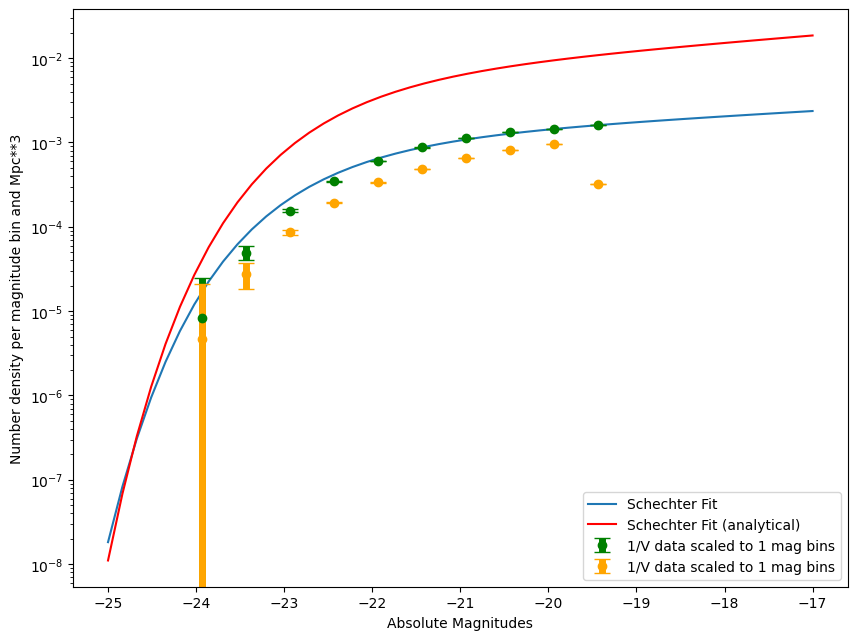

In [201]:
fig, ax = plt.subplots(figsize = (10,7.5))

x = np.linspace(-25, -17)

#ax.plot(x, schechter_fit(x), label = "Schechter Fit")
ax.plot(x, schechter_fit_scaled(x), label = f"Schechter Fit")
#ax.errorbar(np.array(fit_data["ABS_MAG_R"]), np.array(fit_data["N"]), err, label = "1/V data", fmt = "x", linewidth=2, capsize=6)
ax.errorbar(np.array(fit_data_scaled["ABS_MAG_R_center_sc"]), np.array(fit_data_scaled["N_sc"]), phi_j_sigma, label = "1/V data scaled to 1 mag bins", fmt='o', linewidth=5, capsize=6, color = "green")
#ax.errorbar(np.array(fit_data_scaled["ABS_MAG_R_center_sc"]), np.array(fit_data_scaled["N_sc"]), np.array(y_err_uplow).T, label = "1/V data scaled to 1 mag bins", fmt='o', linewidth=1, capsize=6, color = "red")

ax.plot(x, schechter_fit_analytical_scaled(x), label = f"Schechter Fit (analytical)", color = "red")
ax.errorbar(np.array(fit_data_scaled["ABS_MAG_R_center_sc"]), np.array(fit_data_scaled["N_dist_sc"]), phi_j_sigma, label = "1/V data scaled to 1 mag bins", fmt='o', linewidth=5, capsize=6, color = "orange")


#ax.vlines(fit_data["ABS_MAG_R"][fit_lim], 0,1, label = "lower limit of fit", color = "red")
#ax.vlines(fit_data["ABS_MAG_R"][lower_fit_limit], 0,1, label = "limit of normal (unscaled) fit", color = "red")

ax.set_yscale('log')
#ax.set_ylim(10**-9, 10**-1)
ax.legend(loc = "lower right")
ax.set_xlabel("Absolute Magnitudes")
ax.set_ylabel("Number density per magnitude bin and Mpc**3")
plt.savefig("Schechter Fit.png", dpi = 300)
plt.show()

In [175]:
len(lum_bins_center_scaled), len(np.array(count[1:])/100000000)

(10, 10)

In [176]:
fit_data_scaled["ABS_MAG_R_sc"]
# Todo
# initial vals
# boundaries
# include errors ~ 0.002 or more*random_number
# 5logh

# M-5*log(h)

KeyError: 'ABS_MAG_R_sc'

In [ ]:
5*np.log10(0.7)

In [ ]:
np.max(np.array(fit_data["N"]))